QUANTIUM VIRTUAL INTERNSHIP

RETAIL STRATEGY AND ANALYTICS (TASK 2)

In [2]:
# Load required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")


In [3]:
# Looad dataset
QVI_data = pd.read_csv('QVI_data.csv')

In [4]:
QVI_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,Natural,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,CCs,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,Smiths,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,Smiths,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,Kettle,MIDAGE SINGLES/COUPLES,Budget


Select control stores

The client has selected store numbers 77, 86 and 88 as trial stores and wants control stores to be established stores that are operational for the entire
observation period.

We would want to match trial stores to control stores that are similar to the trial store prior to the trial period of Feb 2019 in terms of :

- Monthly overall sales revenue

- Monthly number of customers

- Monthly number of transactions per customer

In [5]:
# Convert the DATE column to datetime format and create a YEARMONTH column
QVI_data['DATE'] = pd.to_datetime(QVI_data['DATE'])
QVI_data['YEARMONTH'] = QVI_data['DATE'].dt.strftime('%Y%m')

In [6]:
QVI_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,YEARMONTH
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,Natural,YOUNG SINGLES/COUPLES,Premium,201810
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,CCs,MIDAGE SINGLES/COUPLES,Budget,201905
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,Smiths,MIDAGE SINGLES/COUPLES,Budget,201905
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,Smiths,MIDAGE SINGLES/COUPLES,Budget,201808
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,Kettle,MIDAGE SINGLES/COUPLES,Budget,201808


Create the metrics of interest and filter to stores that are present throughout the pre-trial period

In [7]:
# Define the measure calculations
measure_over_time = (
    QVI_data.groupby(['STORE_NBR', 'YEARMONTH'])
    .agg(
        totSales=('TOT_SALES', 'sum'),
        nCustomers=('LYLTY_CARD_NBR', pd.Series.nunique),
        nTxnPerCust=('TXN_ID', lambda x: x.nunique() / QVI_data.loc[x.index, 'LYLTY_CARD_NBR'].nunique()),
        nChipsPerTxn=('PROD_QTY', lambda x: x.sum() / QVI_data.loc[x.index, 'TXN_ID'].nunique()),
        avgPricePerUnit=('TOT_SALES', lambda x: x.sum() / QVI_data.loc[x.index, 'PROD_QTY'].sum())
    )
    .reset_index()
    .sort_values(by=['STORE_NBR', 'YEARMONTH'])
)

In [8]:
measure_over_time.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,188.9,47,1.042553,1.183673,3.256897
1,1,201808,168.4,41,1.000000,1.268293,3.238462
2,1,201809,268.1,57,1.035088,1.203390,3.776056
3,1,201810,175.4,39,1.025641,1.275000,3.439216
4,1,201811,184.8,44,1.022727,1.222222,3.360000


Filter to the Pre-Trial Period and Stores with Full Observation Periods

In [9]:
# Filter to stores with full observation periods (12 months)
stores_with_full_obs = measure_over_time.groupby('STORE_NBR').filter(lambda x: len(x) == 12)['STORE_NBR'].unique()

In [10]:
measure_over_time['YEARMONTH'] = measure_over_time['YEARMONTH'].astype(int)
measure_over_time['STORE_NBR'] = measure_over_time['STORE_NBR'].astype(int)


# Filter to the pre-trial period and stores with full observation periods
pre_trial_measures = measure_over_time[
    (measure_over_time['YEARMONTH'] < 201902) & 
    (measure_over_time['STORE_NBR'].isin(stores_with_full_obs))
]

In [11]:
pre_trial_measures.head(8)

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,188.9,47,1.042553,1.183673,3.256897
1,1,201808,168.4,41,1.000000,1.268293,3.238462
2,1,201809,268.1,57,1.035088,1.203390,3.776056
3,1,201810,175.4,39,1.025641,1.275000,3.439216
4,1,201811,184.8,44,1.022727,1.222222,3.360000
5,1,201812,160.6,37,1.081081,1.200000,3.345833
6,1,201901,149.7,35,1.000000,1.171429,3.651220
12,2,201807,140.5,36,1.055556,1.131579,3.267442


Rank how similar each potential control store is to the trial store. We can calculate how correlated the performance of each
store is to the trial store.

1. Create a Function to Calculate Correlation

This will be used to calculate the correlation of each trial store

In [12]:
def calculate_correlation(input_table, metric_col, store_comparison):
    calc_corr_table = pd.DataFrame(columns=['Store1', 'Store2', 'corr_measure'])
    
    # Extract the store numbers from the input table
    store_numbers = input_table['STORE_NBR'].unique()
    
    for i in store_numbers:
        if i != store_comparison:  # Avoid comparing the store with itself
            store1_data = input_table[input_table['STORE_NBR'] == store_comparison][metric_col].values
            store2_data = input_table[input_table['STORE_NBR'] == i][metric_col].values
            
            # Calculate the correlation
            corr_measure = pd.Series(store1_data).corr(pd.Series(store2_data))
            
            # Create a DataFrame with the correlation result
            calculated_measure = pd.DataFrame({
                'Store1': [store_comparison],
                'Store2': [i],
                'corr_measure': [corr_measure]
            })
            
            # Append the result to the correlation table
            calc_corr_table = pd.concat([calc_corr_table, calculated_measure], ignore_index=True)
    
    return calc_corr_table

2. Standardized Magnitude Distance

This will be used to calculate the magnitude distance of each trial store

In [13]:
def calculate_magnitude_distance(input_table, metric_col, store_comparison):
    # Create an empty DataFrame to store the results
    calc_dist_table = pd.DataFrame(columns=['Store1', 'Store2', 'YEARMONTH', 'measure'])
    
    # Get unique store numbers
    store_numbers = input_table['STORE_NBR'].unique()
    
    # Loop through each control store to calculate the magnitude distance
    for i in store_numbers:
        if i != store_comparison:  # Avoid comparing the store with itself
            store1_data = input_table[input_table['STORE_NBR'] == store_comparison]
            store2_data = input_table[input_table['STORE_NBR'] == i]
            
            # Calculate the absolute difference for the specified metric
            calculated_measure = pd.DataFrame({
                'Store1': store_comparison,
                'Store2': i,
                'YEARMONTH': store1_data['YEARMONTH'],
                'measure': abs(store1_data[metric_col].values - store2_data[metric_col].values)
            })
            
            # Append the results to the main table
            calc_dist_table = pd.concat([calc_dist_table, calculated_measure], ignore_index=True)
    
    # Standardize the magnitude distance so that the measure ranges from 0 to 1
    min_max_dist = calc_dist_table.groupby(['Store1', 'YEARMONTH']).agg(
        minDist=('measure', 'min'),
        maxDist=('measure', 'max')
    ).reset_index()
    
    dist_table = pd.merge(calc_dist_table, min_max_dist, on=['Store1', 'YEARMONTH'])
    dist_table['magnitudeMeasure'] = 1 - (dist_table['measure'] - dist_table['minDist']) / (dist_table['maxDist'] - dist_table['minDist'])
    
    # Calculate the mean magnitude measure for each store comparison
    final_dist_table = dist_table.groupby(['Store1', 'Store2']).agg(
        mag_measure=('magnitudeMeasure', 'mean')
    ).reset_index()
    
    return final_dist_table

We can use the functions above to find the control stores

We'll select control stores based on how similar monthly total sales in dollar amounts and monthly number of customers are to the trial stores. So we will need to use our functions to get four scores, two for each of total sales and total customers.

TRIAL STORE 77

Calculate Correlation Metrics and  Magnitude Distance Metrics

Create a composite score that combines the correlation and magnitude scores for each driver

In [14]:
# Define the trial store number
trial_store = 77

In [15]:
# Calculate correlations
corr_nSales = calculate_correlation(pre_trial_measures, 'totSales', trial_store)
corr_nCustomers = calculate_correlation(pre_trial_measures, 'nCustomers', trial_store)

In [16]:
# Calculate magnitude distances
magnitude_nSales = calculate_magnitude_distance(pre_trial_measures, 'totSales', trial_store)
magnitude_nCustomers = calculate_magnitude_distance(pre_trial_measures, 'nCustomers', trial_store)

In [17]:
# Display the results
print("Correlation of Sales:")
print(corr_nSales)

print("\nCorrelation of Customers:")
print(corr_nCustomers)

print("\nMagnitude Distance of Sales:")
print(magnitude_nSales)

print("\nMagnitude Distance of Customers:")
print(magnitude_nCustomers)

Correlation of Sales:
    Store1 Store2  corr_measure
0       77      1     -0.005382
1       77      2     -0.251183
2       77      3      0.660447
3       77      4     -0.347846
4       77      5     -0.139048
..     ...    ...           ...
253     77    268      0.395460
254     77    269     -0.466370
255     77    270      0.274854
256     77    271      0.195190
257     77    272     -0.179647

[258 rows x 3 columns]

Correlation of Customers:
    Store1 Store2  corr_measure
0       77      1      0.337866
1       77      2     -0.596492
2       77      3      0.755249
3       77      4     -0.305412
4       77      5      0.224768
..     ...    ...           ...
253     77    268      0.369736
254     77    269     -0.247581
255     77    270     -0.009182
256     77    271      0.023635
257     77    272      0.068677

[258 rows x 3 columns]

Magnitude Distance of Sales:
     Store1  Store2  mag_measure
0        77       1     0.953691
1        77       2     0.937207
2     

Calculate a combined score by taking a simple average of the correlation and magnitude scores, with a customizable weight for the correlation score

In [18]:
# Define the weight for the correlation score
corr_weight = 0.5

In [19]:
# Combine correlation and magnitude scores for total sales
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on=['Store1', 'Store2'])
score_nSales['scoreNSales'] = (score_nSales['corr_measure'] * corr_weight + score_nSales['mag_measure'] * (1 - corr_weight))

In [20]:
# Combine correlation and magnitude scores for number of customers
score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on=['Store1', 'Store2'])
score_nCustomers['scoreNCust'] = (score_nCustomers['corr_measure'] * corr_weight + score_nCustomers['mag_measure'] * (1 - corr_weight))

In [21]:
# Display the combined scores
print("Combined Score for Sales:")
print(score_nSales[['Store1', 'Store2', 'scoreNSales']])

print("Combined Score for Customers:")
print(score_nCustomers[['Store1', 'Store2', 'scoreNCust']])

Combined Score for Sales:
    Store1 Store2  scoreNSales
0       77      1     0.474154
1       77      2     0.343012
2       77      3     0.502939
3       77      4    -0.083389
4       77      5     0.213041
..     ...    ...          ...
253     77    268     0.679559
254     77    269    -0.005577
255     77    270     0.366640
256     77    271     0.383947
257     77    272     0.356588

[258 rows x 3 columns]
Combined Score for Customers:
    Store1 Store2 scoreNCust
0       77      1    0.63849
1       77      2    0.15612
2       77      3   0.549204
3       77      4  -0.051576
4       77      5   0.369174
..     ...    ...        ...
253     77    268   0.656626
254     77    269    0.05742
255     77    270   0.190912
256     77    271   0.274077
257     77    272   0.508414

[258 rows x 3 columns]


Combine the scores for total sales and number of customers, then select the control store that is most similar to the trial store

In [22]:
# Combine scores across the drivers (total sales and number of customers)
score_control = pd.merge(score_nSales, score_nCustomers, on=['Store1', 'Store2'])
score_control.head()

,Store1,Store2,corr_measure_x,mag_measure_x,scoreNSales,corr_measure_y,mag_measure_y,scoreNCust
0,77,1,-0.005382,0.953691,0.474154,0.337866,0.939115,0.63849
1,77,2,-0.251183,0.937207,0.343012,-0.596492,0.908732,0.15612
2,77,3,0.660447,0.345432,0.502939,0.755249,0.343159,0.549204
3,77,4,-0.347846,0.181068,-0.083389,-0.305412,0.20226,-0.051576
4,77,5,-0.139048,0.565130,0.213041,0.224768,0.51358,0.369174


In [23]:
# Calculate the final control score as a simple average of the two scores
score_control['finalControlScore'] = (score_control['scoreNSales'] * 0.5 + score_control['scoreNCust'] * 0.5)

In [24]:
# Sort by final control score in descending order and exclude the trial store itself
control_store = score_control[score_control['Store1'] == trial_store].sort_values( by='finalControlScore', ascending=False).iloc[0]['Store2']

In [25]:
# Display the selected control store
print(f"Selected Control Store for Trial Store {trial_store}: {control_store}")

Selected Control Store for Trial Store 77: 233


Store 233 has the highest score hence is selected as the control store for trail store 77

Visualize the trends in total sales before the trial and compare the trial store with the selected control store

In [26]:
# Create a copy of the DataFrame for sales visualization
measure_over_time_sales = measure_over_time.copy()

In [27]:
# Label the stores as "Trial", "Control", or "Other stores"
measure_over_time_sales['Store_type'] = np.where(
    measure_over_time_sales['STORE_NBR'] == trial_store, 'Trial',
    np.where(measure_over_time_sales['STORE_NBR'] == control_store, 'Control', 'Other stores')
)

In [28]:
# Calculate the average total sales by YEARMONTH and Store_type
past_sales = measure_over_time_sales.groupby(['YEARMONTH', 'Store_type']).agg({'totSales': 'mean'}).reset_index()

In [29]:
# Create a TransactionMonth column for plotting
past_sales['TransactionMonth'] = pd.to_datetime(past_sales['YEARMONTH'].astype(str) + '01', format='%Y%m%d').dt.strftime('%b %Y')

In [30]:
# Filter to the period before trial
past_sales['YEARMONTH'] = past_sales['YEARMONTH'].astype(int)

past_sales = past_sales[past_sales['YEARMONTH'] < 201903]
past_sales

,YEARMONTH,Store_type,totSales,TransactionMonth
0,201807,Control,271.200000,Jul 2018
1,201807,Other stores,587.690458,Jul 2018
2,201807,Trial,268.400000,Jul 2018
3,201808,Control,260.700000,Aug 2018
4,201808,Other stores,562.888314,Aug 2018
5,201808,Trial,247.500000,Aug 2018
6,201809,Control,220.900000,Sep 2018
7,201809,Other stores,571.073282,Sep 2018
8,201809,Trial,216.800000,Sep 2018
9,201810,Control,159.300000,Oct 2018


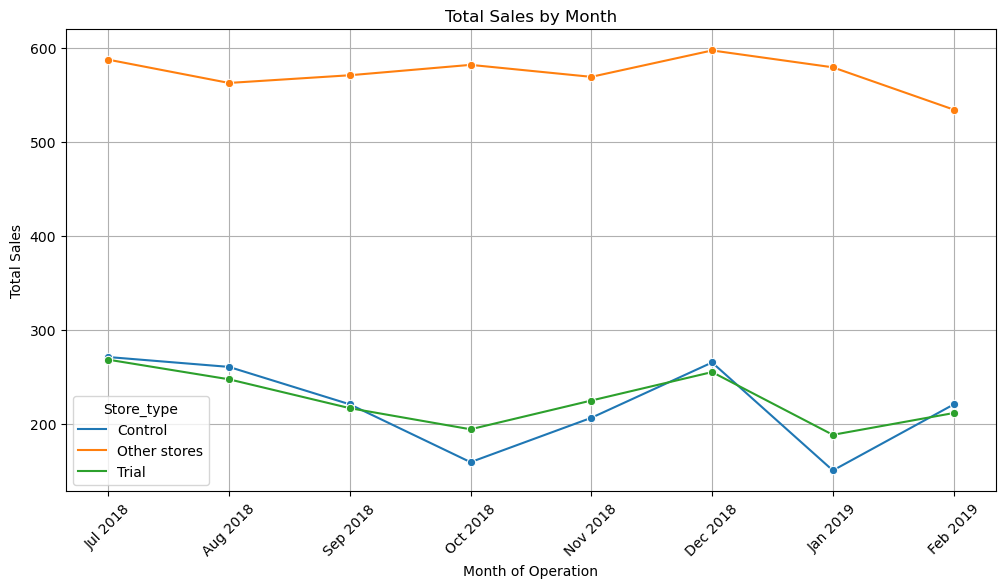

In [31]:
# Create a custom palette with different shades of green
green_palette = sns.color_palette("Greens", n_colors=past_sales['Store_type'].nunique())
# Plot the total sales over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=past_sales, x='TransactionMonth', y='totSales', hue='Store_type', marker='o', color='green_palette')
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

Number of customers

Visualize the number of customers over time and compare the trial store with the control store

In [32]:
# Create a copy of the DataFrame for customers visualization
measure_over_time_customers = measure_over_time.copy()

In [33]:
# Label the stores as "Trial", "Control", or "Other stores"
measure_over_time_customers['Store_type'] = np.where(
    measure_over_time_customers['STORE_NBR'] == trial_store, 'Trial',
    np.where(measure_over_time_customers['STORE_NBR'] == control_store, 'Control', 'Other stores')
)

In [34]:
# Calculate the average number of customers by YEARMONTH and Store_type
past_customers = measure_over_time_customers.groupby(['YEARMONTH', 'Store_type']).agg({'nCustomers': 'mean'}).reset_index()

In [35]:
# Create a TransactionMonth column for plotting
past_customers['TransactionMonth'] = pd.to_datetime(past_customers['YEARMONTH'].astype(str) + '01', format='%Y%m%d').dt.strftime('%b %Y')

In [36]:
# Filter to the period before the trial
past_customers = past_customers[past_customers['YEARMONTH'] < 201903]

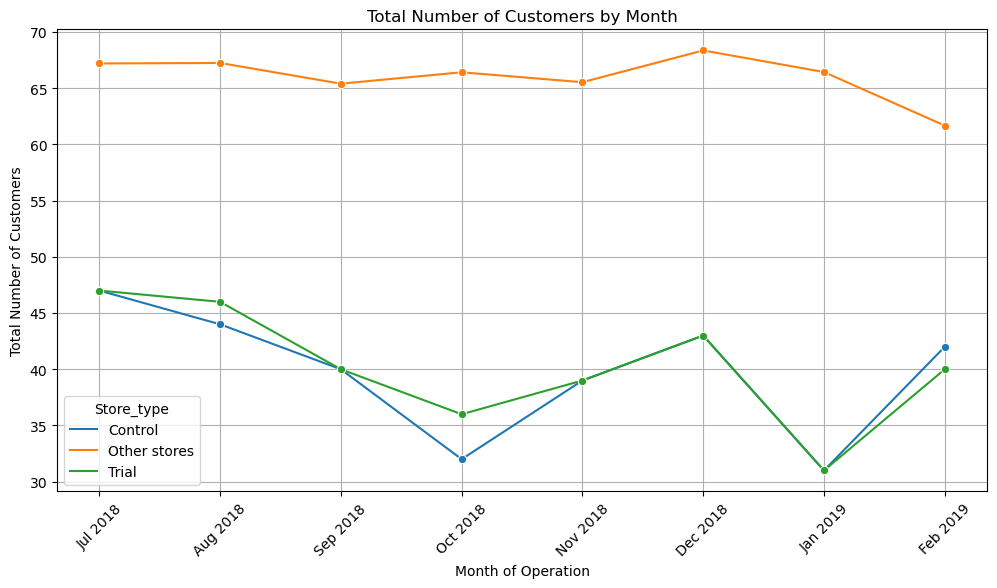

In [37]:
# Plot the number of customers over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=past_customers, x='TransactionMonth', y='nCustomers', hue='Store_type', marker='o')
plt.title('Total Number of Customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Number of Customers')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

ASSESSMENT TRIAL FOR TRIAL STORE 77

Assessment of trial on Total Sales

To assess the trial's impact on chip sales, we start by scaling the control store's pre-trial sales to match the pre-trial sales of the trial store. After scaling, we'll calculate the percentage difference between the scaled control sales and the trial store's sales during the trial period.

Apply the Scaling Factor

Adjust the control store’s sales by multiplying it with the scaling factor so that the sales figures are comparable.

In [38]:
# Calculate the scaling factor based on pre-trial sales
pre_trial_sales_trial = pre_trial_measures[(pre_trial_measures['STORE_NBR'] == trial_store) & 
                                           (pre_trial_measures['YEARMONTH'] < 201902)]['totSales'].sum()

pre_trial_sales_control = pre_trial_measures[(pre_trial_measures['STORE_NBR'] == control_store) & 
                                             (pre_trial_measures['YEARMONTH'] < 201902)]['totSales'].sum()

scaling_factor_for_control_sales = pre_trial_sales_trial / pre_trial_sales_control

print(f"Scaling Factor for Control Sales: {scaling_factor_for_control_sales}")

Scaling Factor for Control Sales: 1.0397523623330076


In [39]:
# Create a copy of the sales data to apply the scaling factor
measure_over_time_sales = measure_over_time.copy()

# Apply the scaling factor to control store sales
scaled_control_sales = measure_over_time_sales[measure_over_time_sales['STORE_NBR'] == control_store].copy()
scaled_control_sales['controlSales'] = scaled_control_sales['totSales'] * scaling_factor_for_control_sales

In [40]:
print("Scaled control sales:")
scaled_control_sales

Scaled control sales:


,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,controlSales
2695,233,201807,271.2,47,1.042553,1.612245,3.432911,281.980841
2696,233,201808,260.7,44,1.022727,1.600000,3.620833,271.063441
2697,233,201809,220.9,40,1.075000,1.581395,3.248529,229.681297
2698,233,201810,159.3,32,1.000000,1.500000,3.318750,165.632551
2699,233,201811,206.5,39,1.025641,1.525000,3.385246,214.708863
2700,233,201812,265.4,43,1.046512,1.555556,3.791429,275.950277
2701,233,201901,150.5,31,1.000000,1.322581,3.670732,156.482731
2702,233,201902,220.7,42,1.023810,1.488372,3.448438,229.473346
2703,233,201903,180.6,35,1.028571,1.444444,3.473077,187.779277
2704,233,201904,144.2,27,1.037037,1.464286,3.517073,149.932291


Calculate the Percentage Difference

To quantify the difference between the scaled control store sales and the trial store sales during the trial period.

In [41]:
# Merge scaled control sales with trial store sales based on YEARMONTH
percentage_diff = pd.merge(
    scaled_control_sales[['YEARMONTH', 'controlSales']], 
    measure_over_time_sales [measure_over_time_sales ['STORE_NBR'] == trial_store][['YEARMONTH', 'totSales']], 
    on='YEARMONTH'
)

percentage_diff.head()

,YEARMONTH,controlSales,totSales
0,201807,281.980841,268.4
1,201808,271.063441,247.5
2,201809,229.681297,216.8
3,201810,165.632551,194.3
4,201811,214.708863,224.9


In [42]:
# Calculate the percentage difference between trial and control sales
percentage_diff['percentageDiff'] = abs(percentage_diff['controlSales'] - percentage_diff['totSales']) / percentage_diff['controlSales']

Calculate Standard Deviation

Calculate the standard deviation of the percentage difference during the pre-trial period. This will be used to determine the significance of the trial period results.

In [43]:
# Calculate the standard deviation of percentage differences in the pre-trial period
std_dev = percentage_diff[percentage_diff['YEARMONTH'] < 201902]['percentageDiff'].std()
std_dev

0.06363898833418712

Set Degrees of Freedom

There are 8 months in the pre‐trial period,  hence 8 ‐ 1 = 7 degrees of freedom

In [44]:
# Define degrees of freedom (number of pre-trial months - 1)
degrees_of_freedom = 7  # For 8 months in the pre-trial period

In [45]:
# Calculate t-values for each month during the trial period
percentage_diff['tValue'] = (percentage_diff['percentageDiff'] - 0) / std_dev

In [46]:
# Convert YEARMONTH to a proper date format for easier interpretation
percentage_diff['TransactionMonth'] = pd.to_datetime(percentage_diff['YEARMONTH'].astype(str), format='%Y%m').dt.strftime('%b %Y')

Significance Testing

T-Values Calculation

To calculate the t-value for each month during the trial period. The t-value helps in determining the significance of the observed differences.

In [47]:
# Filter for the trial period and select relevant columns
t_values = percentage_diff[(percentage_diff['YEARMONTH'] < 201905) & (percentage_diff['YEARMONTH'] > 201901)][['TransactionMonth', 'tValue']]

print(t_values)

  TransactionMonth     tValue
7         Feb 2019   1.223912
8         Mar 2019   5.633494
9         Apr 2019  11.336505


To interpret the t-values and determine whether the differences observed during the trial period are statistically significant.

If t-values are significantly different from zero (depending on the critical t-value for your degrees of freedom), this suggests that the trial has a significant impact on sales.

Calculation of the 95th percentile of the t-distribution 

In [48]:
# Define degrees of freedom
degrees_of_freedom = 7  # For 8 months in the pre-trial period

In [49]:
# Calculate the 95th percentile of the t-distribution
t_95th_percentile = stats.t.ppf(0.95, df=degrees_of_freedom)

In [50]:
print(t_95th_percentile)

1.894578605061305


This will give you the critical t-value at the 95% confidence level, which can be used to compare against the t-values calculated for the trial period. If any of the calculated t-values exceed this critical value, the differences can be considered statistically significant at the 95% confidence level.

Observation

The t-values for March and April are much larger than the 95th percentile of the t-distribution, indicating that the increase in sales during these months at the trial store is statistically significant when compared to the control store. This means the trial was successful in driving higher sales during these months.

DATA VISUALIZATION

Create a visual comparison of the trial and control store sales along with the 95th and 5th percentile confidence intervals of the control store sales

Total Sales

In [51]:
# Create Store_type column to differentiate between Trial, Control, and Others
measure_over_time_sales['Store_type'] = np.where(measure_over_time_sales['STORE_NBR'] == trial_store, 
                                              'Trial', 
                                              np.where(measure_over_time_sales['STORE_NBR'] == control_store, 
                                                       'Control', 
                                                       'Other stores'))

In [52]:
# Calculate the 95th and 5th percentile confidence intervals
stdDev = np.std(percentage_diff[percentage_diff['YEARMONTH'] < 201902]['percentageDiff'])
stdDev

0.05891825452898135

In [53]:
# Calculate mean total sales by month and store type
past_sales = measure_over_time_sales.groupby(['YEARMONTH', 'Store_type'], as_index=False)['totSales'].mean()

# Convert YEARMONTH to TransactionMonth
past_sales['TransactionMonth'] = pd.to_datetime(past_sales['YEARMONTH'].astype(str), format='%Y%m').dt.strftime('%b %Y')

# Filter for Trial and Control stores
past_sales = past_sales[past_sales['Store_type'].isin(['Trial', 'Control'])]

In [54]:
# Create a DataFrame for Control 95th % confidence interval
past_sales_Controls95 = past_sales[past_sales['Store_type'] == "Control"].copy()
past_sales_Controls95['totSales'] *= (1 + stdDev * 2)
past_sales_Controls95['Store_type'] = "Control 95th % confidence interval"

# Display the resulting DataFrame
print("Control store 95th percentile confidence interval:")
past_sales_Controls95

Control store 95th percentile confidence interval:


,YEARMONTH,Store_type,totSales,TransactionMonth
0,201807,Control 95th % confidence interval,303.157261,Jul 2018
3,201808,Control 95th % confidence interval,291.419978,Aug 2018
6,201809,Control 95th % confidence interval,246.930085,Sep 2018
9,201810,Control 95th % confidence interval,178.071356,Oct 2018
12,201811,Control 95th % confidence interval,230.833239,Nov 2018
15,201812,Control 95th % confidence interval,296.673810,Dec 2018
18,201901,Control 95th % confidence interval,168.234395,Jan 2019
21,201902,Control 95th % confidence interval,246.706518,Feb 2019
24,201903,Control 95th % confidence interval,201.881274,Mar 2019
27,201904,Control 95th % confidence interval,161.192025,Apr 2019


In [55]:
# Create a DataFrame for Control 5th % confidence interval
past_sales_Controls5 = past_sales[past_sales['Store_type'] == "Control"].copy()
past_sales_Controls5['totSales'] *= (1 - stdDev * 2)
past_sales_Controls5['Store_type'] = "Control 5th % confidence interval"

# Display the resulting DataFrame
print("Control store 5th percentile confidence interval:")
past_sales_Controls5

Control store 5th percentile confidence interval:


,YEARMONTH,Store_type,totSales,TransactionMonth
0,201807,Control 5th % confidence interval,239.242739,Jul 2018
3,201808,Control 5th % confidence interval,229.980022,Aug 2018
6,201809,Control 5th % confidence interval,194.869915,Sep 2018
9,201810,Control 5th % confidence interval,140.528644,Oct 2018
12,201811,Control 5th % confidence interval,182.166761,Nov 2018
15,201812,Control 5th % confidence interval,234.126190,Dec 2018
18,201901,Control 5th % confidence interval,132.765605,Jan 2019
21,201902,Control 5th % confidence interval,194.693482,Feb 2019
24,201903,Control 5th % confidence interval,159.318726,Mar 2019
27,201904,Control 5th % confidence interval,127.207975,Apr 2019


In [56]:
# Combine all data into one DataFrame
trialAssessment = pd.concat([past_sales, past_sales_Controls95, past_sales_Controls5])

In [57]:
trialAssessment

,YEARMONTH,Store_type,totSales,TransactionMonth
0,201807,Control,271.200000,Jul 2018
2,201807,Trial,268.400000,Jul 2018
3,201808,Control,260.700000,Aug 2018
5,201808,Trial,247.500000,Aug 2018
6,201809,Control,220.900000,Sep 2018
8,201809,Trial,216.800000,Sep 2018
9,201810,Control,159.300000,Oct 2018
11,201810,Trial,194.300000,Oct 2018
12,201811,Control,206.500000,Nov 2018
14,201811,Trial,224.900000,Nov 2018


Plot the Data

In [58]:
# Filter for the trial period 
start_trial_period = (trialAssessment['TransactionMonth'] == 'Feb 2019')

end_trial_period = (trialAssessment['TransactionMonth'] <= 'Jun 2019')

In [59]:
start_date = trialAssessment[start_trial_period]['TransactionMonth'].max()
end_date = trialAssessment[end_trial_period]['TransactionMonth'].min()

print(f"Highlighted period: {start_date} to {end_date}")

Highlighted period: Feb 2019 to Apr 2019


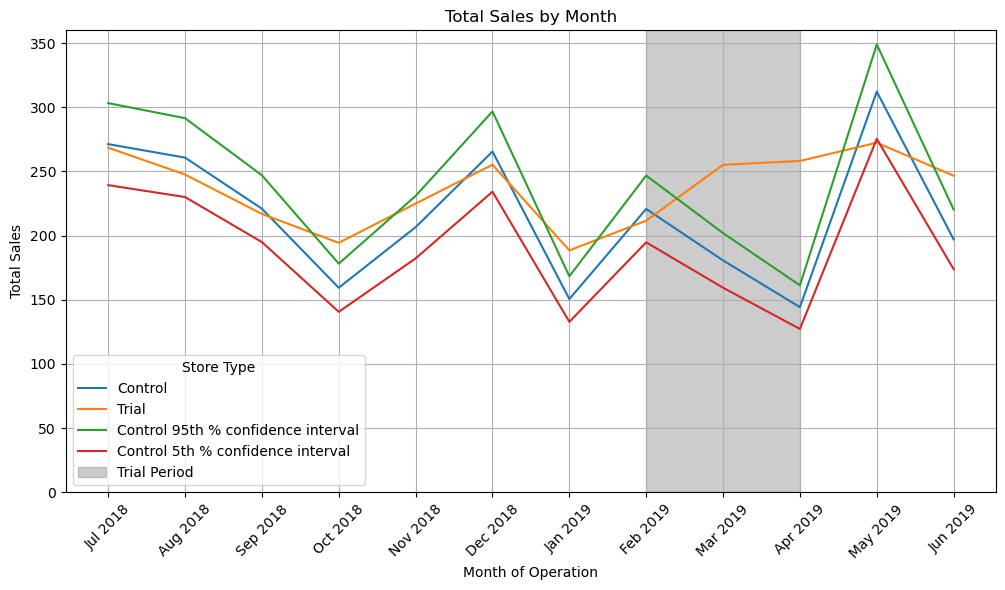

In [61]:
plt.figure(figsize=(12, 6))

# Plot the sales data with confidence intervals
sns.lineplot(data=trialAssessment, x='TransactionMonth', y='totSales', hue='Store_type')

# Highlight the trial period with a shaded rectangle
plt.axvspan(start_date, end_date, color='gray', alpha=0.4, label='Trial Period') 
            
# Customize the plot
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')

# Set y-axis limit to start at 0
plt.ylim(0, None)

plt.legend(title='Store Type')
plt.grid(True)
plt.xticks(rotation=45)

plt.show()

INTERPRETATION 

The plot shows the sales trends for the trial store, control store, and the 95th and 5th percentile confidence intervals of the control store:

1. Trial Store (Trial): This represents the sales of the trial store over time.
2. Control Store (Control): This shows the sales of the control store.
3. 95th & 5th Percentile Intervals: The shaded area between these lines represents the confidence interval within which the control store's sales are expected to fall 95% of the time.

RESULTS / CONCLUSION

The results indicate that the trial conducted in store 77 significantly impacted its performance compared to the control store during the trial period. Specifically, the performance of store 77 fell outside the 5% to 95% confidence interval of the control store's sales in two of the three months of the trial.

This suggests that the observed increase  in sales during the trial period was statistically significant, implying that the trial intervention had a measurable effect on the store's performance. This difference is unlikely to be due to random fluctuations and instead reflects a true change caused by the trial conditions.

Given these findings, it may be concluded that the trial significantly impacted store 77, potentially validating the effectiveness of the changes or strategies implemented during the trial. This outcome could be used to justify wider implementation of the trial conditions across other stores or to refine the approach further.

Assessment Trial For the number of Customers

Calculate Scaling factor

In [62]:
# Calculate the scaling factor based on pre-trial sales
pre_trial_customers_trial = pre_trial_measures[(pre_trial_measures['STORE_NBR'] == trial_store) & 
                                           (pre_trial_measures['YEARMONTH'] < 201902)]['nCustomers'].sum()

pre_trial_customers_control = pre_trial_measures[(pre_trial_measures['STORE_NBR'] == control_store) & 
                                             (pre_trial_measures['YEARMONTH'] < 201902)]['nCustomers'].sum()

scaling_factor = pre_trial_customers_trial / pre_trial_customers_control

print(f"Scaling Factor for Control Customers: {scaling_factor}")

Scaling Factor for Control Customers: 1.0217391304347827


Apply scaling Factor

In [63]:
# Create a copy of the sales data to apply the scaling factor
measure_over_time_cust = measure_over_time.copy()

# Apply the scaling factor to control store sales
scaled_control_cust = measure_over_time_cust[measure_over_time_cust['STORE_NBR'] == control_store].copy()
scaled_control_cust['controlCustomers'] = scaled_control_cust['nCustomers'] * scaling_factor

Calculate the Percentage Difference

To quantify the difference between the scaled control sto customerses and the trial storcustomerses during the trial period.

In [64]:
# Merge scaled control sales with trial store sales based on YEARMONTH
percentage_diff_cust = pd.merge(
    scaled_control_cust[['YEARMONTH', 'controlCustomers']], 
    measure_over_time_cust [measure_over_time_cust ['STORE_NBR'] == trial_store][['YEARMONTH', 'nCustomers']], 
    on='YEARMONTH'
)

In [65]:
# Calculate the percentage difference between trial and control sales
percentage_diff_cust['percentageDiff'] = abs(percentage_diff_cust['controlCustomers'] - percentage_diff_cust['nCustomers']) / percentage_diff_cust['controlCustomers']

In [66]:
# Calculate the standard deviation of percentage differences in the pre-trial period
std_dev = percentage_diff_cust[percentage_diff_cust['YEARMONTH'] < 201902]['percentageDiff'].std()
std_dev

0.030043543491747902

In [67]:
# Define degrees of freedom (number of pre-trial months - 1)
degrees_of_freedom = 7  # For 8 months in the pre-trial period

In [68]:
# Calculate t-values for each month during the trial period
percentage_diff_cust['tValue'] = (percentage_diff_cust['percentageDiff'] - 0) / std_dev

In [69]:
# Convert YEARMONTH to a proper date format for easier interpretation
percentage_diff_cust['TransactionMonth'] = pd.to_datetime(percentage_diff_cust['YEARMONTH'].astype(str), format='%Y%m').dt.strftime('%b %Y')

In [70]:
# Filter for the trial period and select relevant columns
t_values = percentage_diff_cust[(percentage_diff_cust['YEARMONTH'] < 201905) & (percentage_diff_cust['YEARMONTH'] > 201901)][['TransactionMonth', 'tValue']]

print(t_values)

  TransactionMonth     tValue
7         Feb 2019   2.259470
8         Mar 2019   9.530240
9         Apr 2019  23.422793


In [79]:
# Calculate the 95th percentile of the t-distribution
t_95th_percentile = stats.t.ppf(0.95, df=degrees_of_freedom)
print(t_95th_percentile)

1.894578605061305


DATA VISUALIZATION

Create a visual comparison of the trial and control store customers along with the 95th and 5th percentile confidence intervals of the control store customers

In [71]:
# Create Store_type column to differentiate between Trial, Control, and Others
measure_over_time_cust['Store_type'] = np.where(measure_over_time_cust['STORE_NBR'] == trial_store, 
                                              'Trial', 
                                              np.where(measure_over_time_cust['STORE_NBR'] == control_store, 
                                                       'Control', 
                                                       'Other stores'))

In [72]:
# Calculate the 95th and 5th percentile confidence intervals
stdDev = np.std(percentage_diff_cust[percentage_diff_cust['YEARMONTH'] < 201902]['percentageDiff'])
stdDev

0.027814916433051028

In [73]:
# Calculate mean total sales by month and store type
past_cust = measure_over_time_sales.groupby(['YEARMONTH', 'Store_type'], as_index=False)['nCustomers'].mean()

# Convert YEARMONTH to TransactionMonth
past_cust['TransactionMonth'] = pd.to_datetime(past_cust['YEARMONTH'].astype(str), format='%Y%m').dt.strftime('%b %Y')

# Filter for Trial and Control stores
past_cust = past_cust[past_cust['Store_type'].isin(['Trial', 'Control'])]

In [74]:
# Create a DataFrame for Control 95th % confidence interval
past_cust_Controls95 = past_cust[past_cust['Store_type'] == "Control"].copy()
past_cust_Controls95['nCustomers'] *= (1 + stdDev * 2)
past_cust_Controls95['Store_type'] = "Control 95th % confidence interval"

# Display the resulting DataFrame
print("Control store 95th percentile confidence interval:")
past_cust_Controls95

Control store 95th percentile confidence interval:


,YEARMONTH,Store_type,nCustomers,TransactionMonth
0,201807,Control 95th % confidence interval,49.614602,Jul 2018
3,201808,Control 95th % confidence interval,46.447713,Aug 2018
6,201809,Control 95th % confidence interval,42.225193,Sep 2018
9,201810,Control 95th % confidence interval,33.780155,Oct 2018
12,201811,Control 95th % confidence interval,41.169563,Nov 2018
15,201812,Control 95th % confidence interval,45.392083,Dec 2018
18,201901,Control 95th % confidence interval,32.724525,Jan 2019
21,201902,Control 95th % confidence interval,44.336453,Feb 2019
24,201903,Control 95th % confidence interval,36.947044,Mar 2019
27,201904,Control 95th % confidence interval,28.502005,Apr 2019


In [75]:
# Create a DataFrame for Control 5th % confidence interval
past_cust_Controls5 = past_cust[past_cust['Store_type'] == "Control"].copy()
past_cust_Controls5['nCustomers'] *= (1 - stdDev * 2)
past_cust_Controls5['Store_type'] = "Control 5th % confidence interval"

# Display the resulting DataFrame
print("Control store 5th percentile confidence interval:")
past_cust_Controls5

Control store 5th percentile confidence interval:


,YEARMONTH,Store_type,nCustomers,TransactionMonth
0,201807,Control 5th % confidence interval,44.385398,Jul 2018
3,201808,Control 5th % confidence interval,41.552287,Aug 2018
6,201809,Control 5th % confidence interval,37.774807,Sep 2018
9,201810,Control 5th % confidence interval,30.219845,Oct 2018
12,201811,Control 5th % confidence interval,36.830437,Nov 2018
15,201812,Control 5th % confidence interval,40.607917,Dec 2018
18,201901,Control 5th % confidence interval,29.275475,Jan 2019
21,201902,Control 5th % confidence interval,39.663547,Feb 2019
24,201903,Control 5th % confidence interval,33.052956,Mar 2019
27,201904,Control 5th % confidence interval,25.497995,Apr 2019


In [76]:
# Combine all data into one DataFrame
Cust_trialAssessment = pd.concat([past_cust, past_cust_Controls95, past_cust_Controls5])

In [77]:
Cust_trialAssessment

,YEARMONTH,Store_type,nCustomers,TransactionMonth
0,201807,Control,47.000000,Jul 2018
2,201807,Trial,47.000000,Jul 2018
3,201808,Control,44.000000,Aug 2018
5,201808,Trial,46.000000,Aug 2018
6,201809,Control,40.000000,Sep 2018
8,201809,Trial,40.000000,Sep 2018
9,201810,Control,32.000000,Oct 2018
11,201810,Trial,36.000000,Oct 2018
12,201811,Control,39.000000,Nov 2018
14,201811,Trial,39.000000,Nov 2018


Plot the Data

In [78]:
# Filter for the trial period 
start_trial_period = (Cust_trialAssessment['TransactionMonth'] == 'Feb 2019')

end_trial_period = (Cust_trialAssessment['TransactionMonth'] <= 'Jun 2019')

In [79]:
start_date = Cust_trialAssessment[start_trial_period]['TransactionMonth'].max()
end_date = Cust_trialAssessment[end_trial_period]['TransactionMonth'].min()

print(f"Highlighted period: {start_date} to {end_date}")

Highlighted period: Feb 2019 to Apr 2019


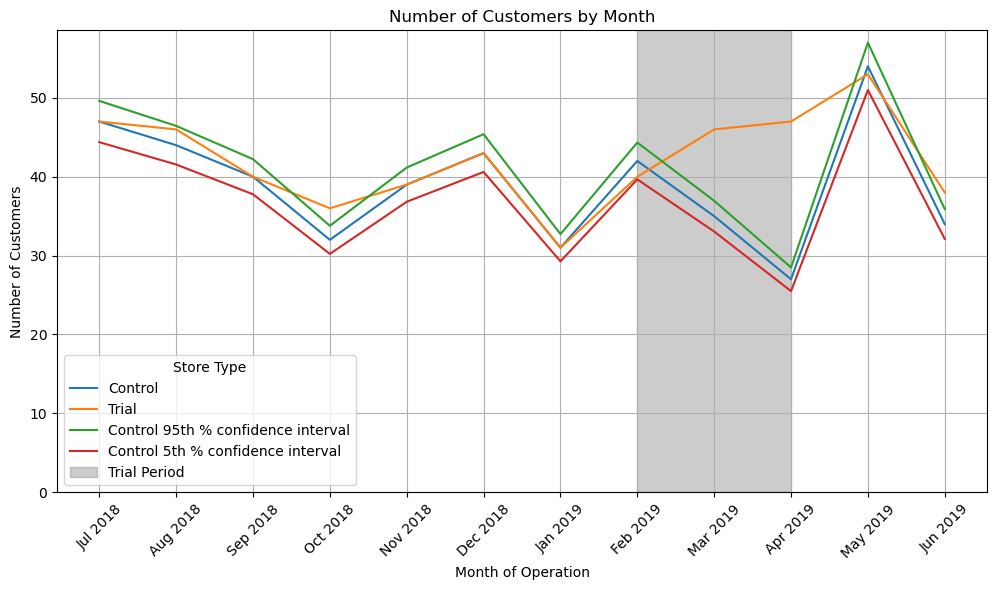

In [80]:
plt.figure(figsize=(12, 6))

# Plot the sales data with confidence intervals
sns.lineplot(data=Cust_trialAssessment, x='TransactionMonth', y='nCustomers', hue='Store_type')

# Highlight the trial period with a shaded rectangle
plt.axvspan(start_date, end_date, color='gray', alpha=0.4, label='Trial Period') 
            
# Customize the plot
plt.title('Number of Customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Number of Customers')

# Set y-axis limit to start at 0
plt.ylim(0, None)

plt.legend(title='Store Type')
plt.grid(True)
plt.xticks(rotation=45)


plt.show()

RESULTS / CONCLUSION

The results indicate that the trial conducted in store 77 significantly impacted its performance compared to the control store during the trial period. Specifically, the performance of store 77 fell outside the 5% to 95% confidence interval of the control store's customers in the three months of the trial.

This suggests that the observed increase in customers during the trial period was statistically significant, implying that the trial intervention had a measurable effect on the store's performance. 

Given these findings, it may be concluded that the trial significantly impacted store 77, potentially validating the effectiveness of the changes or strategies implemented during the trial. This outcome could be used to justify wider implementation of the trial conditions across other stores or to refine the approach further.

TRIAL STORE 86

Calculate Correlation Metrics and Magnitude Distance Metrics For trial store 86

Create a composite score that combines the correlation and magnitude scores for each driver

In [81]:
measure_over_time = QVI_data.groupby(['STORE_NBR', 'YEARMONTH']).agg(
    totSales=('TOT_SALES', 'sum'),
    nCustomers=('LYLTY_CARD_NBR', 'nunique'),
    nTxnPerCust=('TXN_ID', lambda x: x.nunique() / QVI_data['LYLTY_CARD_NBR'].nunique()),
    nChipsPerTxn=('PROD_QTY', lambda x: x.sum() / QVI_data['TXN_ID'].nunique()),
    avgPricePerUnit=('TOT_SALES', lambda x: x.sum() / QVI_data['PROD_QTY'].sum())
).reset_index().sort_values(by=['STORE_NBR', 'YEARMONTH'])

In [82]:
# Define the trial store number
trial_store = 86

In [83]:
# Calculate correlations
corr_nSales = calculate_correlation(pre_trial_measures, 'totSales', trial_store)
corr_nCustomers = calculate_correlation(pre_trial_measures, 'nCustomers', trial_store)

In [84]:
# Calculate magnitude distances
magnitude_nSales = calculate_magnitude_distance(pre_trial_measures, 'totSales', trial_store)
magnitude_nCustomers = calculate_magnitude_distance(pre_trial_measures, 'nCustomers', trial_store)

In [85]:
# Display the results
print("Correlation of Sales:")
print(corr_nSales)

print("\nCorrelation of Customers:")
print(corr_nCustomers)

print("\nMagnitude Distance of Sales:")
print(magnitude_nSales)

print("\nMagnitude Distance of Customers:")
print(magnitude_nCustomers)

Correlation of Sales:
    Store1 Store2  corr_measure
0       86      1      0.364734
1       86      2     -0.526492
2       86      3      0.139789
3       86      4      0.035618
4       86      5      0.446823
..     ...    ...           ...
253     86    268     -0.408070
254     86    269      0.747432
255     86    270     -0.730614
256     86    271      0.557894
257     86    272      0.341567

[258 rows x 3 columns]

Correlation of Customers:
    Store1 Store2  corr_measure
0       86      1      0.384379
1       86      2     -0.064384
2       86      3      0.063780
3       86      4     -0.006242
4       86      5      0.099456
..     ...    ...           ...
253     86    268     -0.024865
254     86    269      0.311707
255     86    270     -0.699535
256     86    271      0.286874
257     86    272     -0.429957

[258 rows x 3 columns]

Magnitude Distance of Sales:
     Store1  Store2  mag_measure
0        86       1     0.216162
1        86       2     0.174258
2     

Calculate a combined score by taking a simple average of the correlation and magnitude scores, with a customizable weight for the correlation score

In [86]:
# Define the weight for the correlation score
corr_weight = 0.5

In [87]:
# Combine correlation and magnitude scores for total sales
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on=['Store1', 'Store2'])
score_nSales['scoreNSales'] = (score_nSales['corr_measure'] * corr_weight + score_nSales['mag_measure'] * (1 - corr_weight))

In [88]:
# Combine correlation and magnitude scores for number of customers
score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on=['Store1', 'Store2'])
score_nCustomers['scoreNCust'] = (score_nCustomers['corr_measure'] * corr_weight + score_nCustomers['mag_measure'] * (1 - corr_weight))

In [89]:
# Display the combined scores
print("Combined Score for Sales:")
print(score_nSales[['Store1', 'Store2', 'scoreNSales']])

print("Combined Score for Customers:")
print(score_nCustomers[['Store1', 'Store2', 'scoreNCust']])

Combined Score for Sales:
    Store1 Store2  scoreNSales
0       86      1     0.290448
1       86      2    -0.176117
2       86      3     0.447627
3       86      4     0.273226
4       86      5     0.679470
..     ...    ...          ...
253     86    268    -0.082227
254     86    269     0.831861
255     86    270     0.055568
256     86    271     0.730714
257     86    272     0.387012

[258 rows x 3 columns]
Combined Score for Customers:
    Store1 Store2 scoreNCust
0       86      1    0.41152
1       86      2   0.148302
2       86      3   0.489744
3       86      4    0.38611
4       86      5   0.502701
..     ...    ...        ...
253     86    268   0.193938
254     86    269   0.618501
255     86    270   0.084864
256     86    271   0.592289
257     86    272  -0.006591

[258 rows x 3 columns]


Combine the scores for total sales and number of customers, then select the control store that is most similar to the trial store


In [90]:
# Combine scores across the drivers (total sales and number of customers)
score_control = pd.merge(score_nSales, score_nCustomers, on=['Store1', 'Store2'])
score_control.head()

,Store1,Store2,corr_measure_x,mag_measure_x,scoreNSales,corr_measure_y,mag_measure_y,scoreNCust
0,86,1,0.364734,0.216162,0.290448,0.384379,0.438662,0.41152
1,86,2,-0.526492,0.174258,-0.176117,-0.064384,0.360989,0.148302
2,86,3,0.139789,0.755466,0.447627,0.063780,0.915708,0.489744
3,86,4,0.035618,0.510835,0.273226,-0.006242,0.778463,0.38611
4,86,5,0.446823,0.912118,0.679470,0.099456,0.905945,0.502701


In [91]:
# Calculate the final control score as a simple average of the two scores
score_control['finalControlScore'] = (score_control['scoreNSales'] * 0.5 + score_control['scoreNCust'] * 0.5)

In [92]:
# Sort by final control score in descending order and exclude the trial store itself
control_store = score_control[score_control['Store1'] == trial_store].sort_values( by='finalControlScore', ascending=False).iloc[0]['Store2']
# Display the selected control store
print(f"Selected Control Store for Trial Store {trial_store}: {control_store}")

Selected Control Store for Trial Store 86: 155


Visualize the trends in total sales before the trial and compare the trial store with the selected control store

In [93]:
# Create a copy of the DataFrame for sales visualization
measure_over_time_sales = measure_over_time.copy()

In [94]:
# Label the stores as "Trial", "Control", or "Other stores"
measure_over_time_sales['Store_type'] = np.where(
    measure_over_time_sales['STORE_NBR'] == trial_store, 'Trial',
    np.where(measure_over_time_sales['STORE_NBR'] == control_store, 'Control', 'Other stores')
)

In [95]:
# Calculate the average total sales by YEARMONTH and Store_type
past_sales = measure_over_time_sales.groupby(['YEARMONTH', 'Store_type']).agg({'totSales': 'mean'}).reset_index()

# Create a TransactionMonth column for plotting
past_sales['TransactionMonth'] = pd.to_datetime(past_sales['YEARMONTH'].astype(str) + '01', format='%Y%m%d').dt.strftime('%b %Y')

past_sales['YEARMONTH'] = past_sales['YEARMONTH'].astype(int)

# Filter to the period before trial
past_sales = past_sales[past_sales['YEARMONTH'] < 201903]

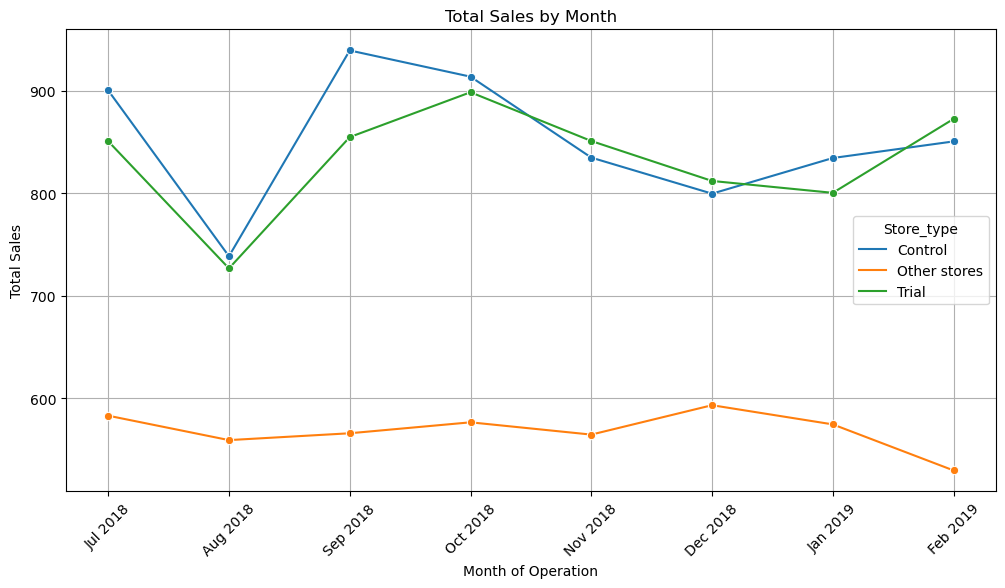

In [96]:
# Plot the total sales over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=past_sales, x='TransactionMonth', y='totSales', hue='Store_type', marker='o')
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

Number of customers

Visualize the number of customers over time and compare the trial store with the control store

In [97]:
# Create a copy of the DataFrame for customers visualization
measure_over_time_customers = measure_over_time.copy()


# Label the stores as "Trial", "Control", or "Other stores"
measure_over_time_customers['Store_type'] = np.where(
    measure_over_time_customers['STORE_NBR'] == trial_store, 'Trial',
    np.where(measure_over_time_customers['STORE_NBR'] == control_store, 'Control', 'Other stores')
)

In [98]:
# Calculate the average number of customers by YEARMONTH and Store_type
past_customers = measure_over_time_customers.groupby(['YEARMONTH', 'Store_type']).agg({'nCustomers': 'mean'}).reset_index()


# Create a TransactionMonth column for plotting
past_customers['TransactionMonth'] = pd.to_datetime(past_customers['YEARMONTH'].astype(str) + '01', format='%Y%m%d').dt.strftime('%b %Y')

past_customers['YEARMONTH'] = past_customers['YEARMONTH'].astype(int)

# Filter to the period before the trial
past_customers = past_customers[past_customers['YEARMONTH'] < 201903]

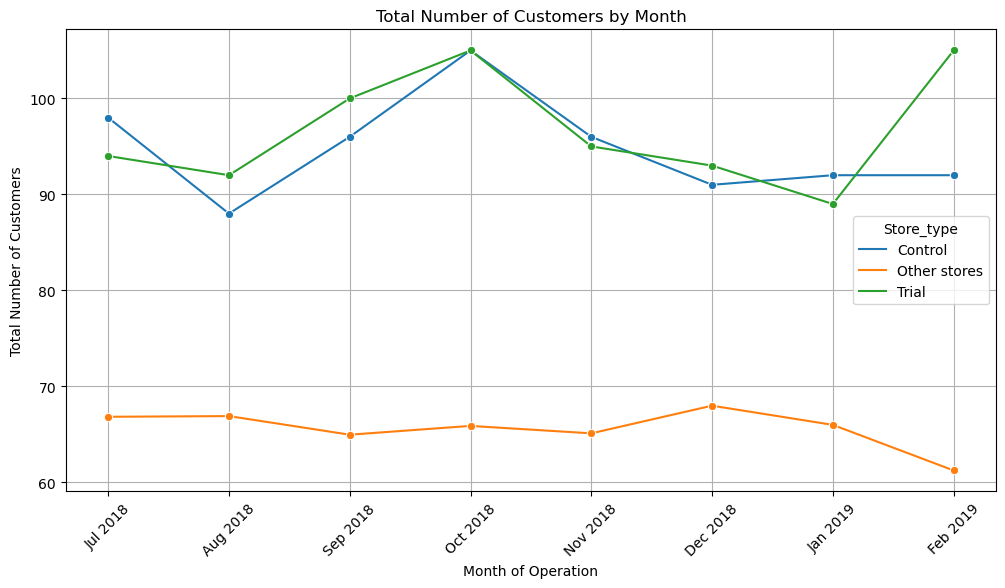

In [99]:
# Plot the number of customers over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=past_customers, x='TransactionMonth', y='nCustomers', hue='Store_type', marker='o')
plt.title('Total Number of Customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Number of Customers')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

ASSESSMENT TRIAL FOR TRIAL STORE 86

To assess the trial's impact on chip sales, we start by scaling the control store's pre-trial sales to match the pre-trial sales of the trial store. After scaling, we'll calculate the percentage difference between the scaled control sales and the trial store's sales during the trial period.

In [100]:
trial_store = 86
control_store = 155

In [101]:
# Calculate the scaling factor based on pre-trial sales
pre_trial_sales_trial = pre_trial_measures[(pre_trial_measures['STORE_NBR'] == trial_store) & 
                                           (pre_trial_measures['YEARMONTH'] < 201902)]['totSales'].sum()

pre_trial_sales_control = pre_trial_measures[(pre_trial_measures['STORE_NBR'] == control_store) & 
                                             (pre_trial_measures['YEARMONTH'] < 201902)]['totSales'].sum()

scaling_factor = pre_trial_sales_trial / pre_trial_sales_control

print(f"Scaling Factor for Control Sales: {scaling_factor_for_control_sales}")

Scaling Factor for Control Sales: 1.0397523623330076


Apply the Scaling Factor

In [102]:
# Create a copy of the sales data to apply the scaling factor
measure_over_time_sales = measure_over_time.copy()

# Apply the scaling factor to control store sales
scaled_control_sales = measure_over_time_sales[measure_over_time_sales['STORE_NBR'] == control_store].copy()
scaled_control_sales['controlSales'] = scaled_control_sales['totSales'] * scaling_factor

In [103]:
print("Scaled control sales:")
scaled_control_sales

Scaled control sales:


,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,controlSales
1792,155,201807,900.60,98,0.001669,0.000979,0.001915,875.427669
1793,155,201808,738.70,88,0.001585,0.000881,0.001570,718.052875
1794,155,201809,939.60,96,0.001824,0.001068,0.001997,913.337595
1795,155,201810,914.00,105,0.001796,0.001044,0.001943,888.453131
1796,155,201811,835.00,96,0.001711,0.001011,0.001775,811.661230
1797,155,201812,799.80,91,0.001571,0.000921,0.001700,777.445092
1798,155,201901,834.60,92,0.001641,0.000962,0.001774,811.272410
1799,155,201902,850.80,92,0.001641,0.000970,0.001809,827.019610
1800,155,201903,767.00,91,0.001543,0.000913,0.001631,745.561872
1801,155,201904,800.40,93,0.001585,0.000930,0.001702,778.028321


Calculate the Percentage Difference

To quantify the difference between the scaled control store sales and the trial store sales during the trial period.

In [104]:
# Merge scaled control sales with trial store sales based on YEARMONTH
percentage_diff = pd.merge(
    scaled_control_sales[['YEARMONTH', 'controlSales']], 
    measure_over_time_sales [measure_over_time_sales ['STORE_NBR'] == trial_store][['YEARMONTH', 'totSales']], 
    on='YEARMONTH'
)
percentage_diff.head()

,YEARMONTH,controlSales,totSales
0,201807,875.427669,851.00
1,201808,718.052875,726.85
2,201809,913.337595,855.00
3,201810,888.453131,898.80
4,201811,811.661230,851.20


In [105]:
# Calculate the percentage difference between trial and control sales
percentage_diff['percentageDiff'] = abs(percentage_diff['controlSales'] - percentage_diff['totSales']) / percentage_diff['controlSales']

Calculate Standard Deviation

Calculate the standard deviation of the percentage difference during the pre-trial period. This will be used to determine the significance of the trial period results.

In [106]:
# Calculate the standard deviation of percentage differences in the pre-trial period
percentage_diff['YEARMONTH'] = percentage_diff['YEARMONTH'].astype(int)

std_dev = percentage_diff[percentage_diff['YEARMONTH'] < 201902]['percentageDiff'].std()
std_dev

0.0209458884462441

In [107]:
# Define degrees of freedom (number of pre-trial months - 1)
degrees_of_freedom = 7  # For 8 months in the pre-trial period

In [108]:
# Calculate t-values for each month during the trial period
percentage_diff['tValue'] = (percentage_diff['percentageDiff'] - 0) / std_dev

# Convert YEARMONTH to a proper date format for easier interpretation
percentage_diff['TransactionMonth'] = pd.to_datetime(percentage_diff['YEARMONTH'].astype(str), format='%Y%m').dt.strftime('%b %Y')

T-Values Calculation

To calculate the t-value for each month during the trial period. The t-value helps in determining the significance of the observed differences.

In [109]:
# Filter for the trial period and select relevant columns
t_values = percentage_diff[(percentage_diff['YEARMONTH'] < 201905) & (percentage_diff['YEARMONTH'] > 201901)][['TransactionMonth', 'tValue']]

print(t_values)

  TransactionMonth     tValue
7         Feb 2019   2.642804
8         Mar 2019  12.796638
9         Apr 2019   1.593697


Observation

The t-values for February and March are much larger than the 95th percentile of the t-distribution, indicating that the increase in sales during these months at the trial store is statistically significant when compared to the control store. This means the trial was successful in driving higher sales during these months.

Calculation of the 95th percentile of the t-distribution

In [110]:
# Calculate the 95th percentile of the t-distribution
t_95th_percentile = stats.t.ppf(0.95, df=degrees_of_freedom)

print(t_95th_percentile)

1.894578605061305


DATA VISUALIZATION (TRIAL STORE 86)

Create a visual comparison of the trial and control store sales along with the 95th and 5th percentile confidence intervals of the control store sales

Total Sales

In [111]:
# Create Store_type column to differentiate between Trial, Control, and Others
measure_over_time_sales['Store_type'] = np.where(measure_over_time_sales['STORE_NBR'] == trial_store, 
                                              'Trial', 
                                              np.where(measure_over_time_sales['STORE_NBR'] == control_store, 
                                                       'Control', 
                                                       'Other stores'))

In [112]:
# Calculate the 95th and 5th percentile confidence intervals
stdDev = np.std(percentage_diff[percentage_diff['YEARMONTH'] < 201902]['percentageDiff'])
stdDev

0.01939212453112645

In [113]:
# Calculate mean total sales by month and store type
past_sales = measure_over_time_sales.groupby(['YEARMONTH', 'Store_type'], as_index=False)['totSales'].mean()

# Convert YEARMONTH to TransactionMonth
past_sales['TransactionMonth'] = pd.to_datetime(past_sales['YEARMONTH'].astype(str), format='%Y%m').dt.strftime('%b %Y')

# Filter for Trial and Control stores
past_sales = past_sales[past_sales['Store_type'].isin(['Trial', 'Control'])]

In [114]:
# Create a DataFrame for Control 95th % confidence interval
past_sales_Controls95 = past_sales[past_sales['Store_type'] == "Control"].copy()
past_sales_Controls95['totSales'] *= (1 + stdDev * 2)
past_sales_Controls95['Store_type'] = "Control 95th % confidence interval"

# Display the resulting DataFrame
print("Control store 95th percentile confidence interval:")
past_sales_Controls95

Control store 95th percentile confidence interval:


,YEARMONTH,Store_type,totSales,TransactionMonth
0,201807,Control 95th % confidence interval,935.529095,Jul 2018
3,201808,Control 95th % confidence interval,767.349925,Aug 2018
6,201809,Control 95th % confidence interval,976.041680,Sep 2018
9,201810,Control 95th % confidence interval,949.448804,Oct 2018
12,201811,Control 95th % confidence interval,867.384848,Nov 2018
15,201812,Control 95th % confidence interval,830.819642,Dec 2018
18,201901,Control 95th % confidence interval,866.969334,Jan 2019
21,201902,Control 95th % confidence interval,883.797639,Feb 2019
24,201903,Control 95th % confidence interval,796.747519,Mar 2019
27,201904,Control 95th % confidence interval,831.442913,Apr 2019


In [115]:
# Create a DataFrame for Control 5th % confidence interval
past_sales_Controls5 = past_sales[past_sales['Store_type'] == "Control"].copy()
past_sales_Controls5['totSales'] *= (1 - stdDev * 2)
past_sales_Controls5['Store_type'] = "Control 5th % confidence interval"

# Display the resulting DataFrame
print("Control store 5th percentile confidence interval:")
past_sales_Controls5

Control store 5th percentile confidence interval:


,YEARMONTH,Store_type,totSales,TransactionMonth
0,201807,Control 5th % confidence interval,865.670905,Jul 2018
3,201808,Control 5th % confidence interval,710.050075,Aug 2018
6,201809,Control 5th % confidence interval,903.158320,Sep 2018
9,201810,Control 5th % confidence interval,878.551196,Oct 2018
12,201811,Control 5th % confidence interval,802.615152,Nov 2018
15,201812,Control 5th % confidence interval,768.780358,Dec 2018
18,201901,Control 5th % confidence interval,802.230666,Jan 2019
21,201902,Control 5th % confidence interval,817.802361,Feb 2019
24,201903,Control 5th % confidence interval,737.252481,Mar 2019
27,201904,Control 5th % confidence interval,769.357087,Apr 2019


In [116]:
# Combine all data into one DataFrame
trialAssessment = pd.concat([past_sales, past_sales_Controls95, past_sales_Controls5])
trialAssessment

,YEARMONTH,Store_type,totSales,TransactionMonth
0,201807,Control,900.600000,Jul 2018
2,201807,Trial,851.000000,Jul 2018
3,201808,Control,738.700000,Aug 2018
5,201808,Trial,726.850000,Aug 2018
6,201809,Control,939.600000,Sep 2018
8,201809,Trial,855.000000,Sep 2018
9,201810,Control,914.000000,Oct 2018
11,201810,Trial,898.800000,Oct 2018
12,201811,Control,835.000000,Nov 2018
14,201811,Trial,851.200000,Nov 2018


Plot the Data

In [117]:
# Filter for the trial period 
start_trial_period = (trialAssessment['TransactionMonth'] == 'Feb 2019')

end_trial_period = (trialAssessment['TransactionMonth'] <= 'Jun 2019')

In [118]:
start_date = trialAssessment[start_trial_period]['TransactionMonth'].max()
end_date = trialAssessment[end_trial_period]['TransactionMonth'].min()

print(f"Highlighted period: {start_date} to {end_date}")

Highlighted period: Feb 2019 to Apr 2019


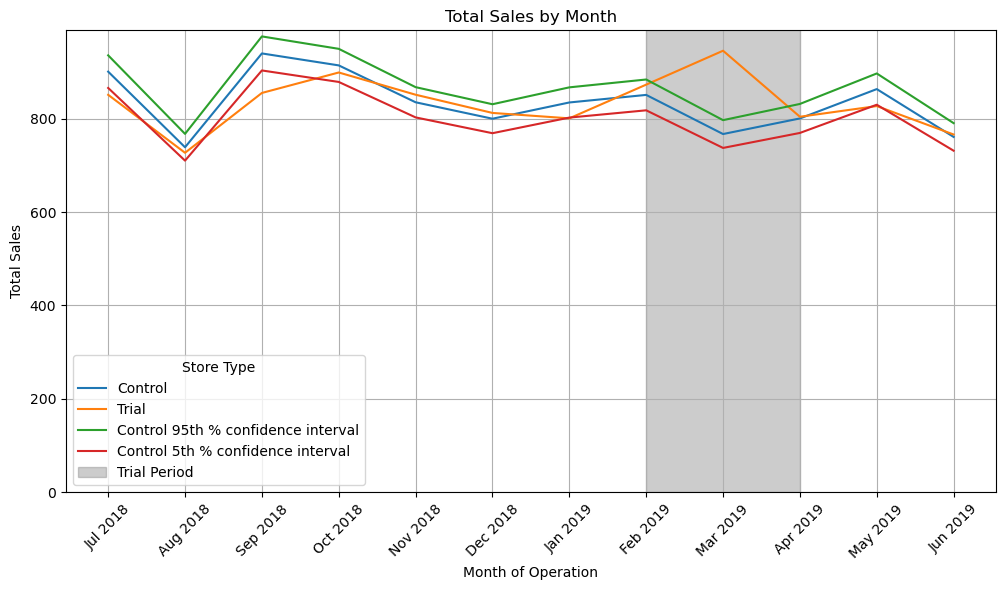

In [119]:
plt.figure(figsize=(12, 6))

# Plot the sales data with confidence intervals
sns.lineplot(data=trialAssessment, x='TransactionMonth', y='totSales', hue='Store_type')

# Highlight the trial period with a shaded rectangle
plt.axvspan(start_date, end_date, color='gray', alpha=0.4, label='Trial Period') 
            
# Customize the plot
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')

# Set y-axis limit to start at 0
plt.ylim(0, None)

plt.legend(title='Store Type')
plt.grid(True)
plt.xticks(rotation=45)

plt.show()


Assessment Trial For the number of Customers

Calculate Scaling factor

In [120]:
# Calculate the scaling factor based on pre-trial sales
pre_trial_customers_trial = pre_trial_measures[(pre_trial_measures['STORE_NBR'] == trial_store) & 
                                           (pre_trial_measures['YEARMONTH'] < 201902)]['nCustomers'].sum()

pre_trial_customers_control = pre_trial_measures[(pre_trial_measures['STORE_NBR'] == control_store) & 
                                             (pre_trial_measures['YEARMONTH'] < 201902)]['nCustomers'].sum()

scaling_factor = pre_trial_customers_trial / pre_trial_customers_control

print(f"Scaling Factor for Control Customers: {scaling_factor}")

Scaling Factor for Control Customers: 1.003003003003003


In [121]:
# Apply scaling Factor
# Create a copy of the sales data to apply the scaling factor
measure_over_time_cust = measure_over_time.copy()

# Apply the scaling factor to control store sales
scaled_control_cust = measure_over_time_cust[measure_over_time_cust['STORE_NBR'] == control_store].copy()
scaled_control_cust['controlCustomers'] = scaled_control_cust['nCustomers'] * scaling_factor

Calculate the Percentage Difference

In [122]:
# Merge scaled control sales with trial store sales based on YEARMONTH
percentage_diff_cust = pd.merge(
    scaled_control_cust[['YEARMONTH', 'controlCustomers']], 
    measure_over_time_cust [measure_over_time_cust ['STORE_NBR'] == trial_store][['YEARMONTH', 'nCustomers']], 
    on='YEARMONTH'
)


# Calculate the percentage difference between trial and control sales
percentage_diff_cust['percentageDiff'] = abs(percentage_diff_cust['controlCustomers'] - percentage_diff_cust['nCustomers']) / percentage_diff_cust['controlCustomers']

In [123]:
# Calculate the standard deviation of percentage differences in the pre-trial period
percentage_diff_cust['YEARMONTH'] = percentage_diff_cust['YEARMONTH'].astype(int)

std_dev = percentage_diff_cust[percentage_diff_cust['YEARMONTH'] < 201902]['percentageDiff'].std()
std_dev

0.016022745840356897

In [124]:
# Define degrees of freedom (number of pre-trial months - 1)
degrees_of_freedom = 7  # For 8 months in the pre-trial period

In [125]:
# Calculate t-values for each month during the trial period
percentage_diff_cust['tValue'] = (percentage_diff_cust['percentageDiff'] - 0) / std_dev

In [126]:
# Convert YEARMONTH to a proper date format for easier interpretation
percentage_diff_cust['TransactionMonth'] = pd.to_datetime(percentage_diff_cust['YEARMONTH'].astype(str), format='%Y%m').dt.strftime('%b %Y')

In [127]:
# Filter for the trial period and select relevant columns
t_values = percentage_diff_cust[(percentage_diff_cust['YEARMONTH'] < 201905) & (percentage_diff_cust['YEARMONTH'] > 201901)][['TransactionMonth', 'tValue']]

print(t_values)

  TransactionMonth     tValue
7         Feb 2019   8.605720
8         Mar 2019  11.437481
9         Apr 2019   3.827618


In [128]:
# Calculate the 95th percentile of the t-distribution
t_95th_percentile = stats.t.ppf(0.95, df=degrees_of_freedom)
print(t_95th_percentile)

1.894578605061305


Create a visual comparison of the trial and control store customers along with the 95th and 5th percentile confidence intervals of the control store customers

In [129]:
# Create Store_type column to differentiate between Trial, Control, and Others
measure_over_time_cust['Store_type'] = np.where(measure_over_time_cust['STORE_NBR'] == trial_store, 
                                              'Trial', 
                                              np.where(measure_over_time_cust['STORE_NBR'] == control_store, 
                                                       'Control', 
                                                       'Other stores'))

In [130]:
# Calculate the 95th and 5th percentile confidence intervals
stdDev = np.std(percentage_diff_cust[percentage_diff_cust['YEARMONTH'] < 201902]['percentageDiff'])
stdDev

0.014834180152549455

In [131]:
# Calculate mean total sales by month and store type
past_cust = measure_over_time_sales.groupby(['YEARMONTH', 'Store_type'], as_index=False)['nCustomers'].mean()

# Convert YEARMONTH to TransactionMonth
past_cust['TransactionMonth'] = pd.to_datetime(past_cust['YEARMONTH'].astype(str), format='%Y%m').dt.strftime('%b %Y')

# Filter for Trial and Control stores
past_cust = past_cust[past_cust['Store_type'].isin(['Trial', 'Control'])]

In [132]:
# Create a DataFrame for Control 95th % confidence interval
past_cust_Controls95 = past_cust[past_cust['Store_type'] == "Control"].copy()
past_cust_Controls95['nCustomers'] *= (1 + stdDev * 2)
past_cust_Controls95['Store_type'] = "Control 95th % confidence interval"

# Display the resulting DataFrame
print("Control store 95th percentile confidence interval:")
past_cust_Controls95

Control store 95th percentile confidence interval:


,YEARMONTH,Store_type,nCustomers,TransactionMonth
0,201807,Control 95th % confidence interval,100.907499,Jul 2018
3,201808,Control 95th % confidence interval,90.610816,Aug 2018
6,201809,Control 95th % confidence interval,98.848163,Sep 2018
9,201810,Control 95th % confidence interval,108.115178,Oct 2018
12,201811,Control 95th % confidence interval,98.848163,Nov 2018
15,201812,Control 95th % confidence interval,93.699821,Dec 2018
18,201901,Control 95th % confidence interval,94.729489,Jan 2019
21,201902,Control 95th % confidence interval,94.729489,Feb 2019
24,201903,Control 95th % confidence interval,93.699821,Mar 2019
27,201904,Control 95th % confidence interval,95.759158,Apr 2019


In [133]:
# Create a DataFrame for Control 5th % confidence interval
past_cust_Controls5 = past_cust[past_cust['Store_type'] == "Control"].copy()
past_cust_Controls5['nCustomers'] *= (1 - stdDev * 2)
past_cust_Controls5['Store_type'] = "Control 5th % confidence interval"

# Display the resulting DataFrame
print("Control store 5th percentile confidence interval:")
past_cust_Controls5

Control store 5th percentile confidence interval:


,YEARMONTH,Store_type,nCustomers,TransactionMonth
0,201807,Control 5th % confidence interval,95.092501,Jul 2018
3,201808,Control 5th % confidence interval,85.389184,Aug 2018
6,201809,Control 5th % confidence interval,93.151837,Sep 2018
9,201810,Control 5th % confidence interval,101.884822,Oct 2018
12,201811,Control 5th % confidence interval,93.151837,Nov 2018
15,201812,Control 5th % confidence interval,88.300179,Dec 2018
18,201901,Control 5th % confidence interval,89.270511,Jan 2019
21,201902,Control 5th % confidence interval,89.270511,Feb 2019
24,201903,Control 5th % confidence interval,88.300179,Mar 2019
27,201904,Control 5th % confidence interval,90.240842,Apr 2019


In [134]:
# Combine all data into one DataFrame
Cust_trialAssessment = pd.concat([past_cust, past_cust_Controls95, past_cust_Controls5])
Cust_trialAssessment.head()

,YEARMONTH,Store_type,nCustomers,TransactionMonth
0,201807,Control,98.0,Jul 2018
2,201807,Trial,94.0,Jul 2018
3,201808,Control,88.0,Aug 2018
5,201808,Trial,92.0,Aug 2018
6,201809,Control,96.0,Sep 2018


Plot the Data

In [135]:
# Filter for the trial period 
start_trial_period = (Cust_trialAssessment['TransactionMonth'] == 'Feb 2019')

end_trial_period = (Cust_trialAssessment['TransactionMonth'] <= 'Jun 2019')

In [136]:
start_date = Cust_trialAssessment[start_trial_period]['TransactionMonth'].max()
end_date = Cust_trialAssessment[end_trial_period]['TransactionMonth'].min()

print(f"Highlighted period: {start_date} to {end_date}")

Highlighted period: Feb 2019 to Apr 2019


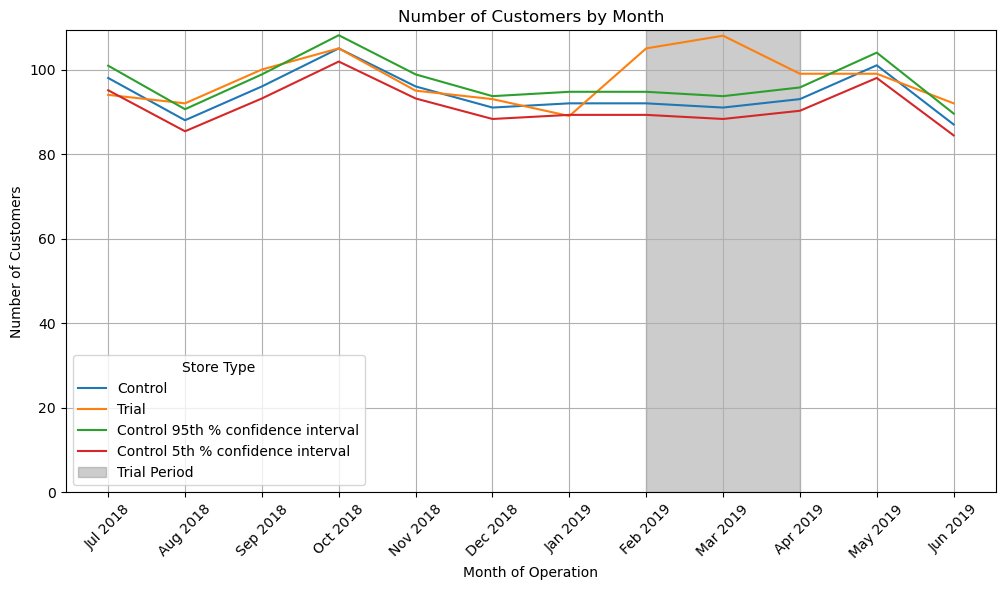

In [137]:
plt.figure(figsize=(12, 6))

# Plot the sales data with confidence intervals
sns.lineplot(data=Cust_trialAssessment, x='TransactionMonth', y='nCustomers', hue='Store_type')

# Highlight the trial period with a shaded rectangle
plt.axvspan(start_date, end_date, color='gray', alpha=0.4, label='Trial Period') 
            
# Customize the plot
plt.title('Number of Customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Number of Customers')

# Set y-axis limit to start at 0
plt.ylim(0, None)

plt.legend(title='Store Type')
plt.grid(True)
plt.xticks(rotation=45)


plt.show()

The number of customers is higher in the three months, hence suggesting that the trial had a significant impact on increasing the number of customers in trial store 86. We can see that sales were not significantly higher.

TRIAL STORE 88

Prepare Data for Store 88

Aggregate the data to get total sales, number of customers, and other metrics for each store and month.


In [138]:
measure_over_time = QVI_data.groupby(['STORE_NBR', 'YEARMONTH']).agg(
    totSales=('TOT_SALES', 'sum'),
    nCustomers=('LYLTY_CARD_NBR', 'nunique'),
    nTxnPerCust=('TXN_ID', lambda x: x.nunique() / QVI_data['LYLTY_CARD_NBR'].nunique()),
    nChipsPerTxn=('PROD_QTY', lambda x: x.sum() / QVI_data['TXN_ID'].nunique()),
    avgPricePerUnit=('TOT_SALES', lambda x: x.sum() / QVI_data['PROD_QTY'].sum())
).reset_index().sort_values(by=['STORE_NBR', 'YEARMONTH'])

In [139]:
# Define the trial store number
trial_store = 88

Calculate the Correlation for Total Sales and Number of Customers

This is used to find how similar the trends in total sales and number of customers in store 88 are to other stores during the pre-trial period.

In [140]:
# Calculate correlations
corr_nSales = calculate_correlation(pre_trial_measures, 'totSales', trial_store)
corr_nCustomers = calculate_correlation(pre_trial_measures, 'nCustomers', trial_store)
# Calculate magnitude distances

magnitude_nSales = calculate_magnitude_distance(pre_trial_measures, 'totSales', trial_store)
magnitude_nCustomers = calculate_magnitude_distance(pre_trial_measures, 'nCustomers', trial_store)

In [141]:
# Display the results
print("Correlation of Sales:")
print(corr_nSales)

print("\nCorrelation of Customers:")
print(corr_nCustomers)

print("\nMagnitude Distance of Sales:")
print(magnitude_nSales)

print("\nMagnitude Distance of Customers:")
print(magnitude_nCustomers)

Correlation of Sales:
    Store1 Store2  corr_measure
0       88      1      0.842232
1       88      2     -0.232494
2       88      3     -0.467330
3       88      4     -0.506130
4       88      5      0.338525
..     ...    ...           ...
253     88    268     -0.201573
254     88    269     -0.101349
255     88    270     -0.695938
256     88    271     -0.160927
257     88    272     -0.645752

[258 rows x 3 columns]

Correlation of Customers:
    Store1 Store2  corr_measure
0       88      1      0.429977
1       88      2     -0.547400
2       88      3      0.434080
3       88      4     -0.216778
4       88      5     -0.026535
..     ...    ...           ...
253     88    268      0.538633
254     88    269     -0.065715
255     88    270     -0.074695
256     88    271     -0.111231
257     88    272     -0.133011

[258 rows x 3 columns]

Magnitude Distance of Sales:
     Store1  Store2  mag_measure
0        88       1     0.141512
1        88       2     0.113873
2     

Combine the correlation and magnitude scores for total sales and number of customers using a weighted average.

In [142]:
corr_weight = 0.5

In [143]:
# Combine correlation and magnitude scores for total sales
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on=['Store1', 'Store2'])
score_nSales['scoreNSales'] = (score_nSales['corr_measure'] * corr_weight + score_nSales['mag_measure'] * (1 - corr_weight))

In [144]:
# Combine correlation and magnitude scores for number of customers
score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on=['Store1', 'Store2'])
score_nCustomers['scoreNCust'] = (score_nCustomers['corr_measure'] * corr_weight + score_nCustomers['mag_measure'] * (1 - corr_weight))

In [145]:
# Display the combined scores
print("Combined Score for Sales:")
print(score_nSales[['Store1', 'Store2', 'scoreNSales']])

print("Combined Score for Customers:")
print(score_nCustomers[['Store1', 'Store2', 'scoreNCust']])

Combined Score for Sales:
    Store1 Store2  scoreNSales
0       88      1     0.491872
1       88      2    -0.059311
2       88      3     0.176239
3       88      4     0.202656
4       88      5     0.470891
..     ...    ...          ...
253     88    268    -0.021309
254     88    269     0.305909
255     88    270     0.006738
256     88    271     0.219049
257     88    272    -0.180525

[258 rows x 3 columns]
Combined Score for Customers:
    Store1 Store2 scoreNCust
0       88      1   0.387606
1       88      2  -0.131746
2       88      3   0.640785
3       88      4   0.359092
4       88      5   0.342825
..     ...    ...        ...
253     88    268   0.431131
254     88    269   0.384091
255     88    270   0.367042
256     88    271   0.297528
257     88    272   0.096869

[258 rows x 3 columns]


Combine Scores Across the Drivers

In [146]:
# Combine scores for total sales and number of customers
score_Control = pd.merge(score_nSales, score_nCustomers, on=['Store1', 'Store2'])
score_Control.head()

,Store1,Store2,corr_measure_x,mag_measure_x,scoreNSales,corr_measure_y,mag_measure_y,scoreNCust
0,88,1,0.842232,0.141512,0.491872,0.429977,0.345234,0.387606
1,88,2,-0.232494,0.113873,-0.059311,-0.547400,0.283908,-0.131746
2,88,3,-0.467330,0.819807,0.176239,0.434080,0.847489,0.640785
3,88,4,-0.506130,0.911441,0.202656,-0.216778,0.934961,0.359092
4,88,5,0.338525,0.603257,0.470891,-0.026535,0.712184,0.342825


In [147]:
# Calculate the final control score
score_Control['finalControlScore'] = (score_Control['scoreNSales'] * 0.5 +  score_Control['scoreNCust'] * 0.5)

In [148]:
# Select the control store based on the highest matching score (excluding the trial store itself)
control_store = score_Control[score_Control['Store1'] == trial_store].sort_values(by='finalControlScore', ascending=False).iloc[0]['Store2']

# Display the selected control store
print(f"Selected Control Store for Trial Store {trial_store}: {control_store}")

Selected Control Store for Trial Store 88: 237


Visualize the trends in total sales before the trial and compare the trial store with the selected control store

In [149]:
# Create a copy of the DataFrame for sales visualization
measure_over_time_sales = measure_over_time.copy()

In [150]:
# Label the stores as "Trial", "Control", or "Other stores"
measure_over_time_sales['Store_type'] = np.where(
    measure_over_time_sales['STORE_NBR'] == trial_store, 'Trial',
    np.where(measure_over_time_sales['STORE_NBR'] == control_store, 'Control', 'Other stores')
)

In [151]:
# Calculate the average total sales by YEARMONTH and Store_type
past_sales = measure_over_time_sales.groupby(['YEARMONTH', 'Store_type']).agg({'totSales': 'mean'}).reset_index()

In [152]:
# Create a TransactionMonth column for plotting
past_sales['TransactionMonth'] = pd.to_datetime(past_sales['YEARMONTH'].astype(str) + '01', format='%Y%m%d').dt.strftime('%b %Y')

past_sales['YEARMONTH'] = past_sales['YEARMONTH'].astype(int)


# Filter to the period before trial
past_sales = past_sales[past_sales['YEARMONTH'] < 201903]

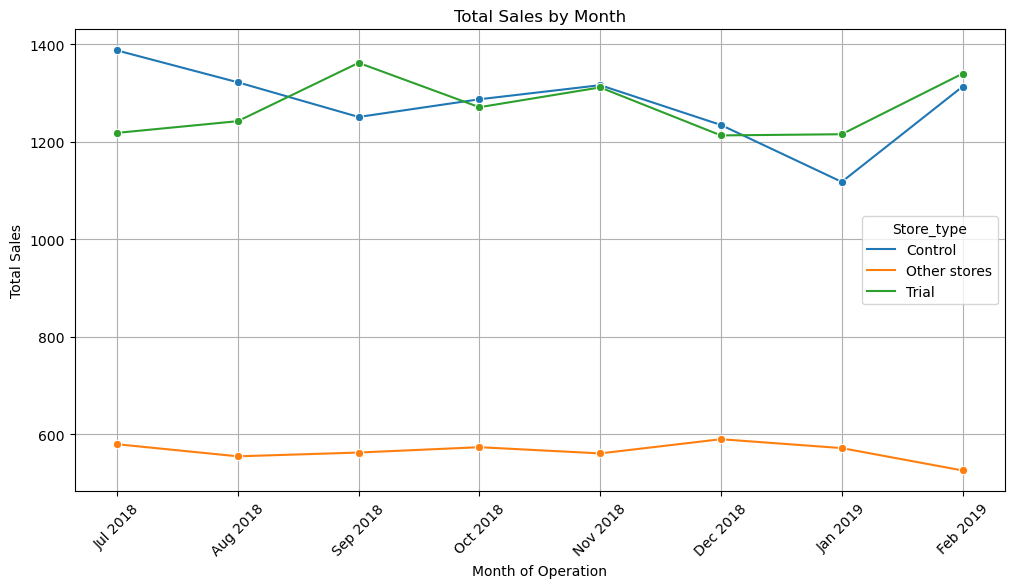

In [153]:
# Plot the total sales over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=past_sales, x='TransactionMonth', y='totSales', hue='Store_type', marker='o')
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

Number of customers

Visualize the number of customers over time and compare the trial store with the control store

In [154]:
# Create a copy of the DataFrame for customers visualization
measure_over_time_customers = measure_over_time.copy()


# Label the stores as "Trial", "Control", or "Other stores"
measure_over_time_customers['Store_type'] = np.where(
    measure_over_time_customers['STORE_NBR'] == trial_store, 'Trial',
    np.where(measure_over_time_customers['STORE_NBR'] == control_store, 'Control', 'Other stores')
)

In [155]:
# Calculate the average number of customers by YEARMONTH and Store_type
past_customers = measure_over_time_customers.groupby(['YEARMONTH', 'Store_type']).agg({'nCustomers': 'mean'}).reset_index()

# Create a TransactionMonth column for plotting
past_customers['TransactionMonth'] = pd.to_datetime(past_customers['YEARMONTH'].astype(str) + '01', format='%Y%m%d').dt.strftime('%b %Y')

past_customers['YEARMONTH'] = past_customers['YEARMONTH'].astype(int)

# Filter to the period before the trial
past_customers = past_customers[past_customers['YEARMONTH'] < 201903]

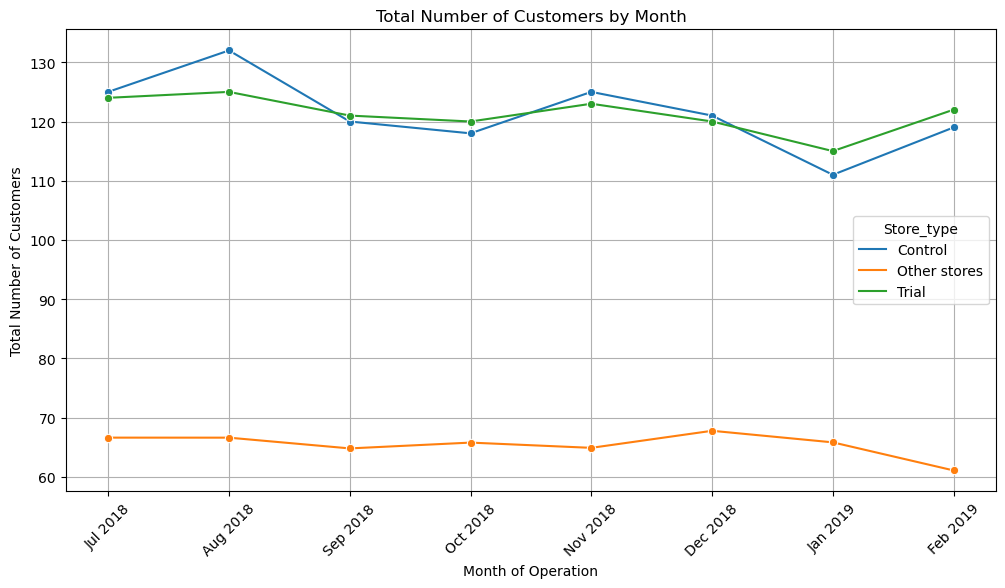

In [156]:
# Plot the number of customers over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=past_customers, x='TransactionMonth', y='nCustomers', hue='Store_type', marker='o')
plt.title('Total Number of Customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Number of Customers')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

From the plot, the total number of customers of the control stores and trial stores are quite similar.

ASSESSMENT TRIAL FOR TRIAL STORE 88

Impact of trial on Total Sales

Scale the control store's pre-trial sales to match the pre-trial sales of the trial store.

In [157]:
trial_store = 88
control_store = 237

In [158]:
# Calculate the scaling factor based on pre-trial sales
pre_trial_sales_trial = pre_trial_measures[(pre_trial_measures['STORE_NBR'] == trial_store) & 
                                           (pre_trial_measures['YEARMONTH'] < 201902)]['totSales'].sum()

pre_trial_sales_control = pre_trial_measures[(pre_trial_measures['STORE_NBR'] == control_store) & 
                                             (pre_trial_measures['YEARMONTH'] < 201902)]['totSales'].sum()

scaling_factor = pre_trial_sales_trial / pre_trial_sales_control

print(f"Scaling Factor for Control Sales: {scaling_factor_for_control_sales}")

Scaling Factor for Control Sales: 1.0397523623330076


Apply Scaling Factor

In [159]:
# Create a copy of the sales data to apply the scaling factor
measure_over_time_sales = measure_over_time.copy()

# Apply the scaling factor to control store sales
scaled_control_sales = measure_over_time_sales[measure_over_time_sales['STORE_NBR'] == control_store].copy()
scaled_control_sales['controlSales'] = scaled_control_sales['totSales'] * scaling_factor

In [160]:
print("Scaled control sales:")
scaled_control_sales

Scaled control sales:


,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,controlSales
2743,237,201807,1387.2,125,0.002188,0.001272,0.002949,1374.394024
2744,237,201808,1321.9,132,0.002244,0.001240,0.002810,1309.696842
2745,237,201809,1250.8,120,0.001992,0.001162,0.002659,1239.253204
2746,237,201810,1287.1,118,0.001978,0.001170,0.002736,1275.218100
2747,237,201811,1316.0,125,0.002146,0.001240,0.002798,1303.851308
2748,237,201812,1234.4,121,0.001978,0.001154,0.002624,1223.004601
2749,237,201901,1117.7,111,0.001810,0.001048,0.002376,1107.381921
2750,237,201902,1313.0,119,0.002076,0.001207,0.002791,1300.879003
2751,237,201903,1177.6,116,0.001838,0.001093,0.002503,1166.728952
2752,237,201904,1153.6,116,0.001824,0.001068,0.002452,1142.950509


Calculate the Percentage Difference

In [161]:
# Merge scaled control sales with trial store sales based on YEARMONTH
percentage_diff = pd.merge(
    scaled_control_sales[['YEARMONTH', 'controlSales']], 
    measure_over_time_sales [measure_over_time_sales ['STORE_NBR'] == trial_store][['YEARMONTH', 'totSales']], 
    on='YEARMONTH'
)
percentage_diff.head()

,YEARMONTH,controlSales,totSales
0,201807,1374.394024,1218.2
1,201808,1309.696842,1242.2
2,201809,1239.253204,1361.8
3,201810,1275.218100,1270.8
4,201811,1303.851308,1311.4


In [162]:
# Calculate the percentage difference between trial and control sales
percentage_diff['percentageDiff'] = abs(percentage_diff['controlSales'] - percentage_diff['totSales']) / percentage_diff['controlSales']

Calculate the standard deviation of the percentage difference during the pre-trial period. This will be used to determine the significance of the trial period results.

In [163]:
# Calculate the standard deviation of percentage differences in the pre-trial period
percentage_diff['YEARMONTH'] = percentage_diff['YEARMONTH'].astype(int)

std_dev = percentage_diff[percentage_diff['YEARMONTH'] < 201902]['percentageDiff'].std()
std_dev

0.049078157781877525

In [164]:
# Define degrees of freedom (number of pre-trial months - 1)
degrees_of_freedom = 7  # For 8 months in the pre-trial period

In [165]:
# Calculate t-values for each month during the trial period
percentage_diff['tValue'] = (percentage_diff['percentageDiff'] - 0) / std_dev

# Convert YEARMONTH to a proper date format for easier interpretation
percentage_diff['TransactionMonth'] = pd.to_datetime(percentage_diff['YEARMONTH'].astype(str), format='%Y%m').dt.strftime('%b %Y')

T-Values Calculation

In [166]:
# Filter for the trial period and select relevant columns
t_values = percentage_diff[(percentage_diff['YEARMONTH'] < 201905) & (percentage_diff['YEARMONTH'] > 201901)][['TransactionMonth', 'tValue']]

print(t_values)

  TransactionMonth    tValue
7         Feb 2019  0.606487
8         Mar 2019  5.243910
9         Apr 2019  3.102824


In [167]:
# Calculate the 95th percentile of the t-distribution
t_95th_percentile = stats.t.ppf(0.95, df=degrees_of_freedom)

print(t_95th_percentile)

1.894578605061305


DATA VISUALIZATION (TRIAL STORE 88)

Create a visual comparison of the trial and control store sales along with the 95th and 5th percentile confidence intervals of the control store sales

Total Sales

In [168]:
# Create Store_type column to differentiate between Trial, Control, and Others
measure_over_time_sales['Store_type'] = np.where(measure_over_time_sales['STORE_NBR'] == trial_store, 
                                              'Trial', 
                                              np.where(measure_over_time_sales['STORE_NBR'] == control_store, 
                                                       'Control', 
                                                       'Other stores'))

The t-values for March and April are much larger than the 95th percentile of the t-distribution, indicating that the increase in sales during these months at the trial store is statistically significant when compared to the control store. This means the trial was successful in driving higher sales during these months.

In [169]:
# Calculate the 95th and 5th percentile confidence intervals
stdDev = np.std(percentage_diff[percentage_diff['YEARMONTH'] < 201902]['percentageDiff'])
stdDev

0.04543754493427087

In [170]:
# Calculate mean total sales by month and store type
past_sales = measure_over_time_sales.groupby(['YEARMONTH', 'Store_type'], as_index=False)['totSales'].mean()

# Convert YEARMONTH to TransactionMonth
past_sales['TransactionMonth'] = pd.to_datetime(past_sales['YEARMONTH'].astype(str), format='%Y%m').dt.strftime('%b %Y')

# Filter for Trial and Control stores
past_sales = past_sales[past_sales['Store_type'].isin(['Trial', 'Control'])]

95th % confidence interval

In [171]:
# Create a DataFrame for Control 95th % confidence interval
past_sales_Controls95 = past_sales[past_sales['Store_type'] == "Control"].copy()
past_sales_Controls95['totSales'] *= (1 + stdDev * 2)
past_sales_Controls95['Store_type'] = "Control 95th % confidence interval"

# Display the resulting DataFrame
print("Control store 95th percentile confidence interval:")
past_sales_Controls95

Control store 95th percentile confidence interval:


,YEARMONTH,Store_type,totSales,TransactionMonth
0,201807,Control 95th % confidence interval,1513.261925,Jul 2018
3,201808,Control 95th % confidence interval,1442.027781,Aug 2018
6,201809,Control 95th % confidence interval,1364.466562,Sep 2018
9,201810,Control 95th % confidence interval,1404.065328,Oct 2018
12,201811,Control 95th % confidence interval,1435.591618,Nov 2018
15,201812,Control 95th % confidence interval,1346.576211,Dec 2018
18,201901,Control 95th % confidence interval,1219.271088,Jan 2019
21,201902,Control 95th % confidence interval,1432.318993,Feb 2019
24,201903,Control 95th % confidence interval,1284.614506,Mar 2019
27,201904,Control 95th % confidence interval,1258.433504,Apr 2019


5th % confidence interval

In [172]:
# Create a DataFrame for Control 5th % confidence interval
past_sales_Controls5 = past_sales[past_sales['Store_type'] == "Control"].copy()
past_sales_Controls5['totSales'] *= (1 - stdDev * 2)
past_sales_Controls5['Store_type'] = "Control 5th % confidence interval"

# Display the resulting DataFrame
print("Control store 5th percentile confidence interval:")
past_sales_Controls5

Control store 5th percentile confidence interval:


,YEARMONTH,Store_type,totSales,TransactionMonth
0,201807,Control 5th % confidence interval,1261.138075,Jul 2018
3,201808,Control 5th % confidence interval,1201.772219,Aug 2018
6,201809,Control 5th % confidence interval,1137.133438,Sep 2018
9,201810,Control 5th % confidence interval,1170.134672,Oct 2018
12,201811,Control 5th % confidence interval,1196.408382,Nov 2018
15,201812,Control 5th % confidence interval,1122.223789,Dec 2018
18,201901,Control 5th % confidence interval,1016.128912,Jan 2019
21,201902,Control 5th % confidence interval,1193.681007,Feb 2019
24,201903,Control 5th % confidence interval,1070.585494,Mar 2019
27,201904,Control 5th % confidence interval,1048.766496,Apr 2019


In [173]:
# Combine all data into one DataFrame
trialAssessment = pd.concat([past_sales, past_sales_Controls95, past_sales_Controls5])
trialAssessment.head()

,YEARMONTH,Store_type,totSales,TransactionMonth
0,201807,Control,1387.2,Jul 2018
2,201807,Trial,1218.2,Jul 2018
3,201808,Control,1321.9,Aug 2018
5,201808,Trial,1242.2,Aug 2018
6,201809,Control,1250.8,Sep 2018


Plot the Data

In [174]:
# Filter for the trial period 
start_trial_period = (trialAssessment['TransactionMonth'] == 'Feb 2019')

end_trial_period = (trialAssessment['TransactionMonth'] <= 'Jun 2019')

In [175]:
start_date = trialAssessment[start_trial_period]['TransactionMonth'].max()
end_date = trialAssessment[end_trial_period]['TransactionMonth'].min()

print(f"Highlighted period: {start_date} to {end_date}")

Highlighted period: Feb 2019 to Apr 2019


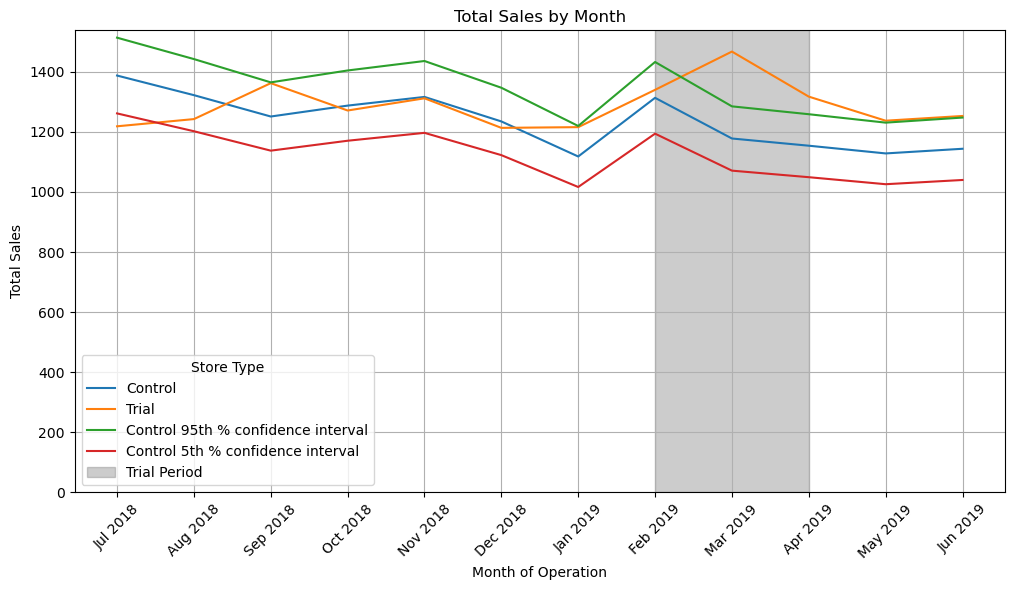

In [176]:
plt.figure(figsize=(12, 6))

# Plot the sales data with confidence intervals
sns.lineplot(data=trialAssessment, x='TransactionMonth', y='totSales', hue='Store_type')

# Highlight the trial period with a shaded rectangle
plt.axvspan(start_date, end_date, color='gray', alpha=0.4, label='Trial Period') 
            
# Customize the plot
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')

# Set y-axis limit to start at 0
plt.ylim(0, None)

plt.legend(title='Store Type')
plt.grid(True)
plt.xticks(rotation=45)

plt.show()

Assessment Trial For the number of Customers

Calculate Scaling factor

In [177]:
# Calculate the scaling factor based on pre-trial sales
pre_trial_customers_trial = pre_trial_measures[(pre_trial_measures['STORE_NBR'] == trial_store) & 
                                           (pre_trial_measures['YEARMONTH'] < 201902)]['nCustomers'].sum()

pre_trial_customers_control = pre_trial_measures[(pre_trial_measures['STORE_NBR'] == control_store) & 
                                             (pre_trial_measures['YEARMONTH'] < 201902)]['nCustomers'].sum()

scaling_factor = pre_trial_customers_trial / pre_trial_customers_control

print(f"Scaling Factor for Control Customers: {scaling_factor}")

Scaling Factor for Control Customers: 0.9953051643192489


In [178]:
# Apply scaling Factor
# Create a copy of the sales data to apply the scaling factor
measure_over_time_cust = measure_over_time.copy()

# Apply the scaling factor to control store sales
scaled_control_cust = measure_over_time_cust[measure_over_time_cust['STORE_NBR'] == control_store].copy()
scaled_control_cust['controlCustomers'] = scaled_control_cust['nCustomers'] * scaling_factor

Calculate the Percentage Difference

In [179]:
# Merge scaled control sales with trial store sales based on YEARMONTH
percentage_diff_cust = pd.merge(
    scaled_control_cust[['YEARMONTH', 'controlCustomers']], 
    measure_over_time_cust [measure_over_time_cust ['STORE_NBR'] == trial_store][['YEARMONTH', 'nCustomers']], 
    on='YEARMONTH'
)

percentage_diff_cust

,YEARMONTH,controlCustomers,nCustomers
0,201807,124.413146,124
1,201808,131.380282,125
2,201809,119.436620,121
3,201810,117.446009,120
4,201811,124.413146,123
5,201812,120.431925,120
6,201901,110.478873,115
7,201902,118.441315,122
8,201903,115.455399,133
9,201904,115.455399,119


In [180]:
# Calculate the percentage difference between trial and control sales
percentage_diff_cust['percentageDiff'] = abs(percentage_diff_cust['controlCustomers'] - percentage_diff_cust['nCustomers']) / percentage_diff_cust['controlCustomers']

In [181]:
# Calculate the standard deviation of percentage differences in the pre-trial period
percentage_diff_cust['YEARMONTH'] = percentage_diff_cust['YEARMONTH'].astype(int)

std_dev = percentage_diff_cust[percentage_diff_cust['YEARMONTH'] < 201902]['percentageDiff'].std()
std_dev

0.017915383598410627

In [182]:
# Calculate t-values for each month during the trial period
percentage_diff_cust['tValue'] = (percentage_diff_cust['percentageDiff'] - 0) / std_dev

In [183]:
# Convert YEARMONTH to a proper date format for easier interpretation
percentage_diff_cust['TransactionMonth'] = pd.to_datetime(percentage_diff_cust['YEARMONTH'].astype(str), format='%Y%m').dt.strftime('%b %Y')

In [184]:
# Filter for the trial period and select relevant columns
t_values = percentage_diff_cust[(percentage_diff_cust['YEARMONTH'] < 201905) & (percentage_diff_cust['YEARMONTH'] > 201901)][['TransactionMonth', 'tValue']]

print(t_values)

  TransactionMonth    tValue
7         Feb 2019  1.677105
8         Mar 2019  8.482095
9         Apr 2019  1.713669


In [185]:
# Calculate the 95th percentile of the t-distribution
t_95th_percentile = stats.t.ppf(0.95, df=degrees_of_freedom)
print(t_95th_percentile)

1.894578605061305


Create a visual comparison of the trial and control store customers along with the 95th and 5th percentile confidence intervals of the control store customers

In [186]:
# Create Store_type column to differentiate between Trial, Control, and Others
measure_over_time_cust['Store_type'] = np.where(measure_over_time_cust['STORE_NBR'] == trial_store, 
                                              'Trial', 
                                              np.where(measure_over_time_cust['STORE_NBR'] == control_store, 
                                                       'Control', 
                                                       'Other stores'))

In [187]:
# Calculate the 95th and 5th percentile confidence intervals
stdDev = np.std(percentage_diff_cust[percentage_diff_cust['YEARMONTH'] < 201902]['percentageDiff'])
stdDev

0.01658642223054406

In [188]:
# Calculate mean total sales by month and store type
past_cust = measure_over_time_sales.groupby(['YEARMONTH', 'Store_type'], as_index=False)['nCustomers'].mean()

# Convert YEARMONTH to TransactionMonth
past_cust['TransactionMonth'] = pd.to_datetime(past_cust['YEARMONTH'].astype(str), format='%Y%m').dt.strftime('%b %Y')

# Filter for Trial and Control stores
past_cust = past_cust[past_cust['Store_type'].isin(['Trial', 'Control'])]

In [189]:
# Create a DataFrame for Control 95th % confidence interval
past_cust_Controls95 = past_cust[past_cust['Store_type'] == "Control"].copy()
past_cust_Controls95['nCustomers'] *= (1 + stdDev * 2)
past_cust_Controls95['Store_type'] = "Control 95th % confidence interval"

# Display the resulting DataFrame
print("Control store 95th percentile confidence interval:")
past_cust_Controls95

Control store 95th percentile confidence interval:


,YEARMONTH,Store_type,nCustomers,TransactionMonth
0,201807,Control 95th % confidence interval,129.146606,Jul 2018
3,201808,Control 95th % confidence interval,136.378815,Aug 2018
6,201809,Control 95th % confidence interval,123.980741,Sep 2018
9,201810,Control 95th % confidence interval,121.914396,Oct 2018
12,201811,Control 95th % confidence interval,129.146606,Nov 2018
15,201812,Control 95th % confidence interval,125.013914,Dec 2018
18,201901,Control 95th % confidence interval,114.682186,Jan 2019
21,201902,Control 95th % confidence interval,122.947568,Feb 2019
24,201903,Control 95th % confidence interval,119.848050,Mar 2019
27,201904,Control 95th % confidence interval,119.848050,Apr 2019


In [190]:
# Create a DataFrame for Control 5th % confidence interval
past_cust_Controls5 = past_cust[past_cust['Store_type'] == "Control"].copy()
past_cust_Controls5['nCustomers'] *= (1 - stdDev * 2)
past_cust_Controls5['Store_type'] = "Control 5th % confidence interval"

# Display the resulting DataFrame
print("Control store 5th percentile confidence interval:")
past_cust_Controls5

Control store 5th percentile confidence interval:


,YEARMONTH,Store_type,nCustomers,TransactionMonth
0,201807,Control 5th % confidence interval,120.853394,Jul 2018
3,201808,Control 5th % confidence interval,127.621185,Aug 2018
6,201809,Control 5th % confidence interval,116.019259,Sep 2018
9,201810,Control 5th % confidence interval,114.085604,Oct 2018
12,201811,Control 5th % confidence interval,120.853394,Nov 2018
15,201812,Control 5th % confidence interval,116.986086,Dec 2018
18,201901,Control 5th % confidence interval,107.317814,Jan 2019
21,201902,Control 5th % confidence interval,115.052432,Feb 2019
24,201903,Control 5th % confidence interval,112.151950,Mar 2019
27,201904,Control 5th % confidence interval,112.151950,Apr 2019


In [191]:
# Combine all data into one DataFrame
Cust_trialAssessment = pd.concat([past_cust, past_cust_Controls95, past_cust_Controls5])
Cust_trialAssessment.head(12)

,YEARMONTH,Store_type,nCustomers,TransactionMonth
0,201807,Control,125.0,Jul 2018
2,201807,Trial,124.0,Jul 2018
3,201808,Control,132.0,Aug 2018
5,201808,Trial,125.0,Aug 2018
6,201809,Control,120.0,Sep 2018
8,201809,Trial,121.0,Sep 2018
9,201810,Control,118.0,Oct 2018
11,201810,Trial,120.0,Oct 2018
12,201811,Control,125.0,Nov 2018
14,201811,Trial,123.0,Nov 2018


Plot the Data

In [192]:
# Filter for the trial period 
start_trial_period = (Cust_trialAssessment['TransactionMonth'] == 'Feb 2019')

end_trial_period = (Cust_trialAssessment['TransactionMonth'] <= 'Jun 2019')

In [193]:
start_date = Cust_trialAssessment[start_trial_period]['TransactionMonth'].max()
end_date = Cust_trialAssessment[end_trial_period]['TransactionMonth'].min()

print(f"Highlighted period: {start_date} to {end_date}")

Highlighted period: Feb 2019 to Apr 2019


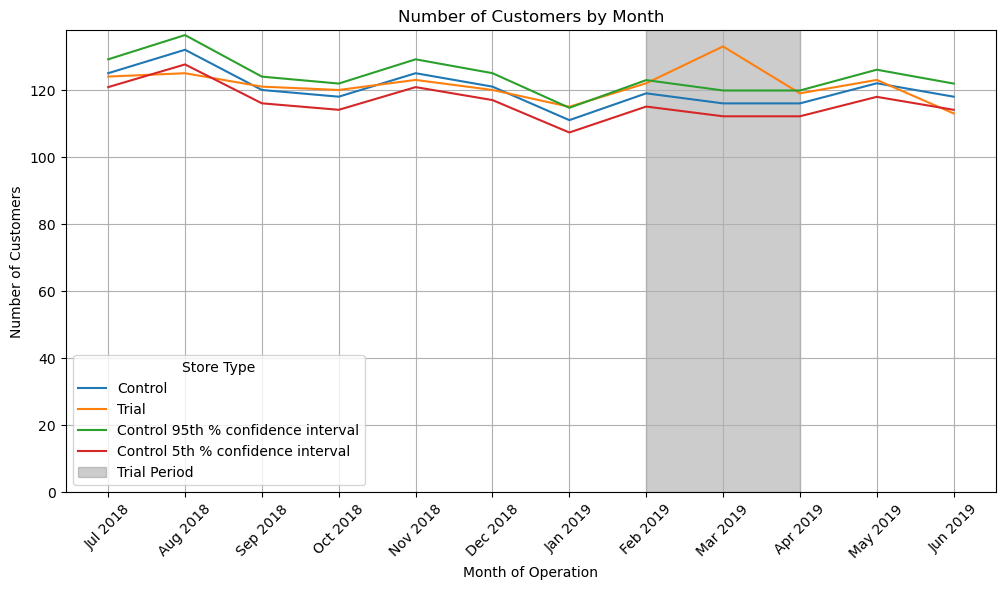

In [194]:
plt.figure(figsize=(12, 6))

# Plot the sales data with confidence intervals
sns.lineplot(data=Cust_trialAssessment, x='TransactionMonth', y='nCustomers', hue='Store_type')

# Highlight the trial period with a shaded rectangle
plt.axvspan(start_date, end_date, color='gray', alpha=0.4, label='Trial Period') 
            
# Customize the plot
plt.title('Number of Customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Number of Customers')

# Set y-axis limit to start at 0
plt.ylim(0, None)

plt.legend(title='Store Type')
plt.grid(True)
plt.xticks(rotation=45)


plt.show()

The total number of customers in the trial period for the trial store is more than the control store.


CONCLUSION

We have identified suitable control stores for each of the trial stores:

Control Store 233 for Trial Store 77
Control Store 155 for Trial Store 86
Control Store 237 for Trial Store 88

1. Trial Store 77: The results show a significant difference in sales during at least two of the three trial months, indicating a positive impact of the trial on sales.

2. Trial Store 88: Similar to Store 77, the trial results for Store 88 also show a significant difference in sales during at least two of the three trial months, suggesting the trial effectively boosted sales.

3. Trial Store 86: Unlike the other trial stores, Store 86 did not show a significant difference in sales during the trial period. This could be due to differences in how the trial was implemented or other factors specific to this store. It would be beneficial to check with the client to see if the trial implementation differed in Store 86.

SUMMARY

Overall, the trial appears to have had a significant positive impact on sales, particularly in stores 77 and 88. The results suggest that the trial strategy effectively increased sales, with some variation in its impact across different stores.